In this script, a working example of how to explore the SMRT function along with optimal estimation (an inverse probalistic problem solver) is shown. The frequencies that will be analyzed will be [6.9, 10.7, 18.7, 23.8, 36.5, 50.0, 89.0, 157.0, 183.0] GHz. This is only done for first year ice, as multi year ice proved much harder to retrieve decent results for. In the script a simple media construction of 3 snow and 2 ice layers is used for the SMRT module. This construction is used because the wind slab snow layer is very important for high frequencies. The thickness of the wind slap layer was set to be 5 cm and the remaining 2 layers each had half of the snow thicknesses. The ice has an upper layer that is 10 cm deep and a bottom layer that has the remaining thickness.

To start off, let's initialize the SMRT module and import packages. For more on how to initialize the SMRT module, see https://smrt-model.science/getstarted.html.

In [1]:
import time; start_script = time.time()
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyOptimalEstimation as pyOE
import scipy.stats as stats
import os, sys
path = os.getcwd()
sys.path.append(f"{path}/smrt")
from smrt import make_model, sensor_list, PSU
from smrt import make_snowpack, make_ice_column, make_model, sensor_list, PSU
# from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
# from smrt import SMRTError 
from matplotlib import cm
import seaborn as sn
from matplotlib.ticker import MaxNLocator, LinearLocator
from seaborn import heatmap
from matplotlib.colors import ListedColormap
import imageio

To reduce the amount of paramaters needed to simulate a realistic sea ice emissivity, a function to generate a complete sea ice profile is created. This function will generate a profile where the temperature, water content, density, autocorrelation length and salinity is described for every cm throughout the snow and the ice. For this project, the water content will be neglected throughout the layers.

In [2]:
def smrt_profile(snowt,icet,Ts,icetype, ACL_growth= 0.01, ACL_exp=3, ACL_bias = 0.04, snow_density_up=250, snow_density_avg = 330):
    #snowt: snow thickness [m]
    #icet: ice thickness [m]
    #Ts: thermometric temperature of the surface 
    #icetype: first- or multiyear ice ['firstyear'/'multiyear']
    
        
    #compute num: layer number, top to bottom
    #total depth in cm
    hs=int(np.floor(snowt*100))
    hi=int(np.floor(icet*100))
    total_depth=int(hs+hi)
    num=np.array(range(total_depth))
    num=num+1
    
    #compute layer thickness 
    di=0.01*np.ones(total_depth)
    
    #comute the thermometric temperature
    Ti=np.zeros(int(total_depth))
    snowtemp=np.zeros(int(hs))
    icetemp=np.zeros(int(hi))
    Tw=271.35
    ks=0.3
    ki=2.1
    #snedybden skal ikke være nul her 
    f=(ks*hi)/(ki*hs) 
    Tsi=(Tw+f*Ts)/(f+1) 
    
    for i in range(hs):
        snowtemp[i]=Ts+i*(Tsi-Ts)/hs 
    for j in range(hi):
        icetemp[j]=Tsi+j*(Tw-Tsi)/hi 
    Ti[0:hs]=snowtemp[:]
    Ti[hs:hs+hi]=icetemp[:]
        
    #water content in the snow
    Wi=np.zeros(total_depth)
    
    #density profile : cox & weeks sammenhaeng mellem massefylde og saltindhold
    roi=np.zeros(total_depth)
    #snow density
    snow_density=np.ones(hs)
    w=int((np.floor(hs/4)))
    if hs < 4: snow_density[:]=snow_density_avg
    else:
        snow_density[0:w]=np.linspace(snow_density_up, snow_density_avg, w).flatten()
        snow_density[w:]=snow_density_avg
        # snow_density=np.flipud(snow_density)
        
    ice_density=np.zeros(hi)
    #First-year ice density (icethickness)
    if icetype=='firstyear': 
        ice_density[:]=926.0
        # ice_density = np.linspace(700, 900, hi)
        
    #Multiyear ice density Hummock (icethickness)
    if icetype=='multiyear':
        humdens=np.zeros(20)
        tdens=800.0
        bdens=860.0
        for i in range(20):
            humdens[i]=tdens+i*(bdens-tdens)/20
        ice_density[0:20]=humdens[:]
        ice_density[20:hi]=bdens
        
    roi[0:hs]=snow_density[:]
    roi[hs:hs+hi]=ice_density[:]
    
    #the scattering correlation length
    snow_grain_size = 20
    pci=np.zeros(total_depth)
    snow_pcc=np.zeros(hs)
    ice_pcc=np.zeros(hi)
    for i in range(hs):
        # snow_pcc[i] = 0.01*snow_grain_size*np.exp(-3.0*(i/hs))+0.07 * # ORIGINAL
        snow_pcc[i] = ACL_growth*snow_grain_size*np.exp(-ACL_exp*(i/hs))+ACL_bias
    snow_pcc=np.flipud(snow_pcc)
    if icetype=='firstyear': ice_pcc[:]=0.1
    elif icetype=='multiyear': 
        ice_pcc[0:5]=0.6
        ice_pcc[5:100]=0.4
        ice_pcc[100:hi]=0.4
    pci[0:hs]=snow_pcc[:]
    pci[hs:hi+hs]=ice_pcc[:]
    
    #the salinity
    snow_sal=np.zeros(hs)
    ice_sal=np.zeros(hi)
    simt=np.zeros(hi)
    sal=np.zeros(total_depth)
    CW2=7.88-1.59*(hi/100.0)  
    
    #First-year ice snow and ice salinity
    if icetype=='firstyear':
        for i in range(hs):
            snow_sal[i] = 2*CW2*np.exp(-10.0*(i/hs))  
        for j in range(hi):
            ice_sal[j]=(2*CW2*np.exp(-5*j/hi)+10.0*j/hi)*np.exp(-8.0*j/hi)+np.exp(2.5*j/hi) 
    elif icetype=='multiyear':
        tsal=0.0
        bsal=5.0
        snow_sal[:]=0.0
        for j in range(hi):
            ice_sal[j]=tsal+j*(bsal-tsal)/hi 
    sal[0:hs]=np.flipud(snow_sal[:]) 
    sal[hs:hi+hs]=ice_sal[:]
   
    typei=np.ones(total_depth)
    snow_type=np.ones(hs)
    idx=(snow_pcc > 0.2)
    snow_type[idx]=2.0
    ice_type=np.ones(hi)
    if icetype=='firstyear': ice_type[:]=3
    elif icetype=='multiyear': ice_type[:]=4
    
    typei[0:hs]=snow_type[:] 
    typei[hs:hs+hi]=ice_type[:]
    
    si=np.zeros(total_depth)
    si[hs:hs+hi]=1.0
    
    return num, di, Ti, Wi, roi, pci, sal, typei, si

For optimal estimation to work, a measurement of brightness temperatures is necessary. In this project, a MEMLS simulation was carried out at 3 different locations and a dataset including Tb and sea-ice paramaters was generated for each of the locations. Now the MEMLS-data for all 3 different locations is loaded. With this data we can look at the correlation between select parameters and brightness temperatures, as well as the correlation between different parameters. We do this in order to find out which parameters that we want to use as free parameters for our optimal estimation algorithm. 

<AxesSubplot:>

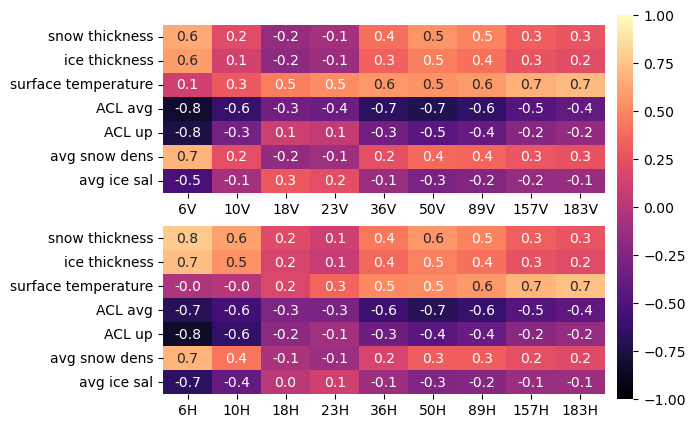

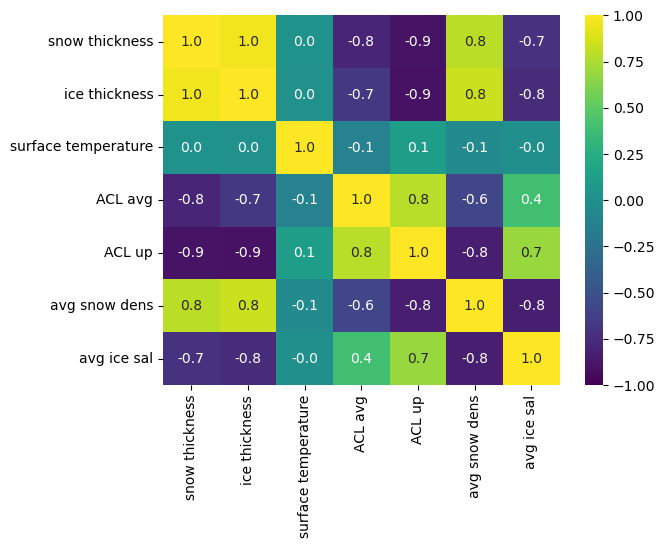

In [3]:
fy_sal1 = np.array(pd.read_csv('new_data/firstyearice1/emipar12.qaan',delimiter=" "))[200:1000] # Site A
fy_sal2 = np.array(pd.read_csv('new_data/firstyearice2/emipar12.qaan',delimiter=" "))[200:1000] # Site B
ross_dataset = np.array(pd.read_csv('new_data/ross/emipar12.qaan',delimiter=" "))[200:1000] # Ross Sea

all_sites = np.concatenate((fy_sal1, fy_sal2, ross_dataset), axis=0)
all_sites = all_sites.astype(float)
#(0) iteration number, (1) 2m air temp [K], (2) mass of precip [kg/m2], (3) snow freeb [m], (4) snow thick [m],
#(5) ice thick [m], (6) thick of first layer [m], (7) dens of first layer [kg/m3], (8) surface temp [K],
#(9) corr length of first layer [mm], (10) avg snow dens [kg/m3], (11) avg snow corr lenght [mm],
#(12) avg snow T [K], (13) avg ice sal [ppt], (14) avg ice T [K], (15) snow ice interf T [K],
#(16)-(35) brightness temperatures V and H 1.4, 6.9, 10.7, 18.7, 31.5, 36.5, 50.0, 89.0, 157.0, 183.0GHz


y_vars = ["6V", "6H", "10V", "10H", "18V", "18H", "23V", "23H", "36V", "36H", "50V", "50H","89V", "89H", "157V", "157H", "183V", "183H"] 
parameter_names = ['snow thickness', 'ice thickness', 'surface temperature', 'ACL avg', 'ACL up', 'avg snow dens', 'avg ice sal']
parameter_loc = [4,5,8,11,9,10, 13]
N = np.size(parameter_names)

corr_V = np.corrcoef(x=all_sites[:, parameter_loc], y=all_sites[:, 18:36:2], rowvar=False)
corr_H = np.corrcoef(x=all_sites[:, parameter_loc], y=all_sites[:, 19:36:2], rowvar=False)

fig, ax = plt.subplots(nrows=2)
fig.subplots_adjust(left=0.2, right=0.89)
axC = fig.add_axes([0.91, 0.1, 0.025, 0.8])
heatmap(corr_V[0:N, N:],
        ax=ax[0], 
        annot=True, fmt='.1f',
        yticklabels=parameter_names, 
        xticklabels=y_vars[::2],
        vmin=-1,
        vmax=1,
        cmap='magma',
        cbar_ax=axC)
heatmap(corr_H[0:N, N:],
        ax=ax[1],
        annot=True, fmt='.1f',
        yticklabels=parameter_names,
        xticklabels=y_vars[1::2],
        vmin=-1,
        vmax=1,
        cmap='magma',
        cbar_ax=axC)

fig, ax = plt.subplots()
display_cov = np.corrcoef(x=all_sites[:, parameter_loc], rowvar=False)
heatmap(display_cov, 
        ax=ax,
        annot=True, fmt='.1f',
        yticklabels=parameter_names,
        xticklabels=parameter_names,
        vmin=-1,
        vmax=1,
        cmap='viridis')



From the illustration above, notice that the brightness temperatures are highly correlated with surface temperature across all channels. Tb are also correlated with snow & ice thickness for multiple channels. It appears that the autocorrelation has a high degree of correlation between some channels, and more importantly that the channels are correlated differently than with the thicknesses and surf temp. The same could be said for salinity.

Our model says that snow and ice thickness are 100% correlated. This could therefore be a good reason to only use 1 of them. The ACL is also highly correlated with snow thickness.

Now that some of the parameters have been picked, log transformation on some of the parameters is explored.

The parameters used for optimal estimation are: snow thickness, ice thickness, surface temperature and ACL avg. Sometimes the ACL in the upper layer of snow is also included, but I think it might be redundant.

In the following, try changing the parameter "X_matrix_used" to either "X_matrix_ross"/"X_matrix" to see the effect that the measurement series from the Ross Sea has on the normality of the data. The parameter "X_matrix_used" is above the for-loop.

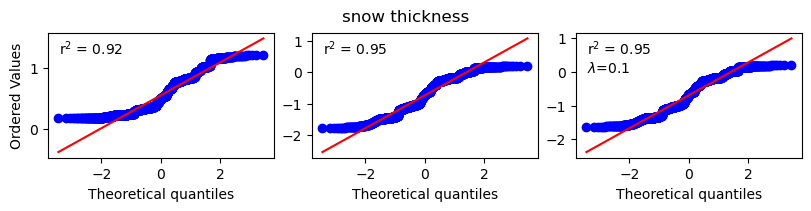

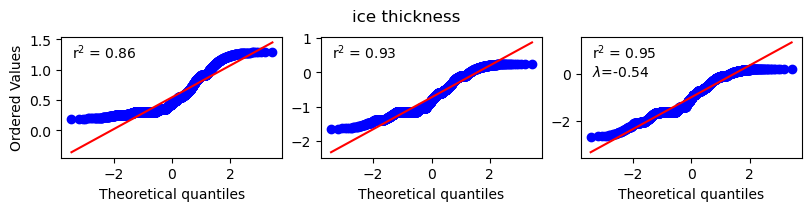

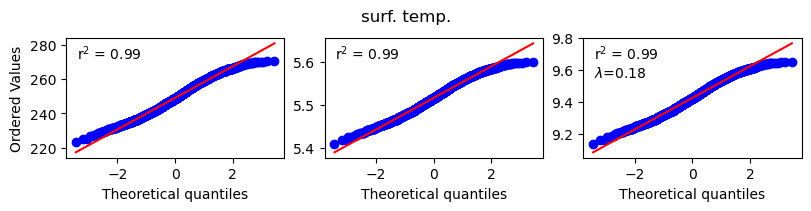

In [4]:
all_sites = np.concatenate((fy_sal1, fy_sal2, ross_dataset), axis=0)
all_sites = (all_sites.astype(float)).T # Transpose the matrix to get paramters in first dimension
#(0) iteration number, (1) 2m air temp [K], (2) mass of precip [kg/m2], (3) snow freeb [m], (4) snow thick [m],
#(5) ice thick [m], (6) thick of first layer [m], (7) dens of first layer [kg/m3], (8) surface temp [K],
#(9) corr length of first layer [mm], (10) avg snow dens [kg/m3], (11) avg snow corr lenght [mm],
#(12) avg snow T [K], (13) avg ice sal [ppt], (14) avg ice T [K], (15) snow ice interf T [K],
#(16)-(35) brightness temperatures V and H 1.4, 6.9, 10.7, 18.7, 31.5, 36.5, 50.0, 89.0, 157.0, 183.0GHz


# Define the X and Y matrices for location A+B
Y_matrix = np.copy(all_sites[18:36,:1600])
X_matrix = np.copy(all_sites[[4, 5, 8, 11, 9], :1600])
X_matrix[[3,4], :] = X_matrix[[3,4], :]*1e-3 # Change the units on ACL to SI [m]

# Define the X and Y matices for locaation A+B+Ross Sea
Y_matrix_ross = np.copy(all_sites[18:36, :])
X_matrix_ross = np.copy(all_sites[[4, 5, 8, 11, 9], :])
X_matrix_ross[[3,4], :] = X_matrix_ross[[3,4], :]*1e-3 # Change the units on ACL to SI [m]

# To decide whether or not the antarctic point should be used or not, lets see if the normality of the dataset is affected
X_matrix_used = np.copy(X_matrix_ross)
Y_matrix_used = Y_matrix_ross # Remember that the X and Y matrices have to come from the same dataset!


# Examine different transformations
x_vars = ['snow thickness', 'ice thickness', 'surf. temp.', 'ACL avg', 'ACL up']
for i in range(X_matrix_used.shape[0]):
    fig, ax = plt.subplots(ncols=3, figsize=(8, 2), layout='constrained')
    fig.suptitle(f'{x_vars[i]}')
    (_,_), (_,_,r0) = stats.probplot(X_matrix_used[i,:], sparams=(), dist='norm', fit=True, plot=ax[0], rvalue=False)
    (_,_), (_,_,r1) = stats.probplot(np.log(X_matrix_used[i,:]), sparams=(), dist='norm', fit=True, plot=ax[1], rvalue=False)
    (_,_), (_,_,r2) = stats.probplot(stats.boxcox(X_matrix_used[i,:])[0], sparams=(), dist='norm', fit=True, plot=ax[2], rvalue=False)
    ax[0].text(0.05, 0.95, f"r$^2$ = {np.round(r0**2,2)}", horizontalalignment='left', verticalalignment='top', transform=ax[0].transAxes)
    ax[1].text(0.05, 0.95, f"r$^2$ = {np.round(r1**2,2)}", horizontalalignment='left', verticalalignment='top', transform=ax[1].transAxes)
    ax[2].text(0.05, 0.95, f"r$^2$ = {np.round(r2**2,2)} \n$\lambda$={np.round(stats.boxcox(X_matrix_used[i,:])[1],2)}", horizontalalignment='left', verticalalignment='top', transform=ax[2].transAxes)
    ax[0].set_title('')
    ax[1].set_title('')
    ax[2].set_title('')
    ax[1].set_ylabel('')
    ax[2].set_ylabel('')


From this plot, we can transform our data to make the distribution as normal as possible. For the sake of simplicity, the Box-Cox transformation is not considered. The choice is therefore between no transformation or log transformation. In this regard, the normality of the parameters are pretty much unaffected by the log transformation, except for the ice thickness which becomes quite a bit more normalized. 

Besides normality, there is another reason to use a log transform on the parameters that are fed to optimal estimation. The reason being the model isn't restricted to only using positive values. For the SMRT model, negative autocorrelation lengths or snow & ice thicknesses make no sense and the model will break if optimal estimation points at a negative solution. This can however be avoided if a log transform is used, as negative logarithmic numbers are positive after being mapped back with the exponential function. 

With this in mind, all parameters will be log transformed except for temperature

In [5]:
logMask = (np.array([1,1,0,1,1]) == 1) # Shows where the log transform has been used

# With the transformation chosen, the new matrix can be defined
X_matrix_ross_t = np.copy(X_matrix_ross)
X_matrix_ross_t[logMask] = np.log(X_matrix_ross_t[logMask])
X_matrix_t = np.copy(X_matrix)
X_matrix_t[logMask] = np.log(X_matrix_t[logMask])

Also define some of the parameters that the SMRT needs.

In [6]:
freqs = np.array([6.9, 10.7, 18.7, 23.8, 36.5, 50.0, 89.0, 157.0, 183.0])*1e9 # Hz
radiometer = sensor_list.passive(frequency = freqs, theta=55)
m = make_model("iba", "dort", rtsolver_options ={"n_max_stream": 32, "phase_normalization": "forced"})

Before I explain the model I will give my thoughts and considerations for the SMRT construction.

The model medium consists of snow and ice. The snow layer was divided into 3 layers. The upper layer is set to be 5 cm deep, while the middle & bottom layer split the rest of the snow thicknesses between them. This implementation was chosen because the wind slab layer has a big impact on the sea ice emissions at high frequencies. This implementation is not necessarily the most realistic, because the bottom layer is typically defined as just touching the ice (a little wet). I chose this implementation because I couldn't think of a way to do this smoothly, but lately I have thought more about it. A possible way to implement this while containing some smoothness is given at the very end of this script, but it is untested.

In the ice medium, the model has 2 layers. The first layer is set to be 10 cm deep and the other layer has the remaining ice thickness. The first ice layer actually has a big impact on the brightness temperatures across all frequencies. I have a pretty good suspicion that this is tied to the salinity of the first ice layer.

To make the model converge, a lot of transformations on the data given by the MEML simulations were explored and some used. 

The way that the layers are constructed has a huge impact on how the brightness temperatures are estimated and the parameters that are necessary for creating a good brightness temperature. To generate a good retreival of the parameters, I suspect that a good snow and ice construction is very important, unless paramater transformations like used in this media construction is used.

Below is an illustration of the media constructions for all the different sites.

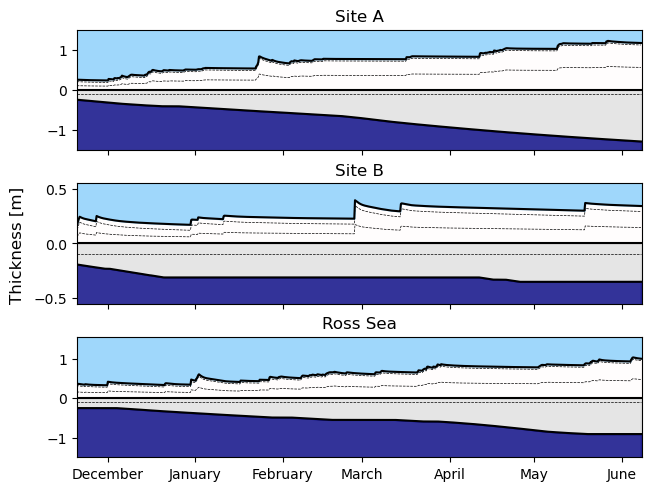

In [7]:
#### Plot showing how the different locations are ##########################
fig, ax = plt.subplots(nrows=3, sharex=True, layout='constrained')
fig.supylabel('Thickness [m]')
# Initialize some arrays to be used in the plotting
snow_split_high = np.repeat(np.nan, X_matrix_ross.shape[1])
snow_split_low = np.repeat(np.nan, X_matrix_ross.shape[1])
for j in range(X_matrix_ross.shape[1]):

    if X_matrix_ross[0,j] >= 0.1:
        snow_split_low[j] = 0.05
        snow_split_high[j] = (0.05+(X_matrix_ross[0,j]-snow_split_low[j])/2)
    else:
        snow_split_low[j] = (0.5*X_matrix_ross[0,j])
        snow_split_high[j] = (snow_split_low[j]+(X_matrix_ross[0,j]-snow_split_low[j])/2)
material = ['Air', 'Snow', 'Ice', 'Water']
text_placement = np.array([[1, 0.35], [0.05, 0.1], [-0.2, -0.15], [-1.1, -0.45]])

for i in range(3):
    index = np.arange(800*i, 800*i+800).astype(int) # The 2 different spots are isolated

    # The ice and snow is drawn
    ax[i].plot(X_matrix_ross[0, index],label='snow_air',color='k')
    ax[i].plot(np.repeat(0, 800),label='Snow_ice', color='k')
    ax[i].plot(-X_matrix_ross[1, index], label='ice_water', color='k')
    ax[i].fill_between(np.arange(0, 800), X_matrix_ross[0, index], np.repeat(0,800),alpha=0.4, color='Snow')
    ax[i].fill_between(np.arange(0, 800), -X_matrix_ross[1, index], np.repeat(0,800),alpha=0.4, color='Silver')
    ax[i].fill_between(np.arange(0, 800), -X_matrix_ross[1, index], np.repeat(-2,800), alpha=0.8, color='Navy')
    ax[i].fill_between(np.arange(0, 800), X_matrix_ross[0, index], np.repeat(2,800),alpha=0.8, color='LightSkyBlue')
    
    ax[i].set_xlim([0, 800])
    
    # The layers in the snow is created
    ax[i].plot(np.repeat(-0.1, 800), label='ice_layer', alpha=1, color='k', linestyle='--', linewidth=0.5)

    # # Upper layer model
    # ax[i].plot(X_matrix_ross[0, index]-X_matrix_ross[7, index], label='ice_layer', alpha=1, color='k', linestyle='--', linewidth=0.5)
    
    # 3 layer model
    ax[i].plot(X_matrix_ross[0, index]-snow_split_high[index], label='ice_layer', alpha=1, color='k', linestyle='--', linewidth=0.5)
    ax[i].plot(X_matrix_ross[0, index]-snow_split_low[index], label='ice_layer', alpha=1, color='k', linestyle='--', linewidth=0.5)
ax[0].set_ylim([-1.5,1.5]); ax[1].set_ylim([-0.55,0.55]); ax[2].set_ylim([-1.5,1.55])
ax[0].set_title('Site A'); ax[1].set_title('Site B'); ax[2].set_title('Ross Sea')

# Trying to show the month of the picture
# The simulation starts the 1st october. I skip the first 200 iterations, meaning that I skip 50 days. Then i am in the 20th November
months =                    ["December", "January", "February", "March", "April", "May", "June"]
month_separators=np.array([11,        42,        73,       101,     132,     162,    193])*4 # This should equal the amount of days until the end of each month from the 20th november
ax[1].set_xticks(month_separators, months)
for label in ax[1].get_xticklabels():
    label.set_rotation(45)

Now that the media construction has been explained and illustrated, the forward function can be implemented. The way that the function is defined makes it easy to change which free parameters and model uncertainties are included in the optimal estimation. Toggling the parameter "setting" should allow you to try different setups with the function. The current settings are described below. I found that the ACL in the upper layer of snow was a redundant parameter that wasn't necessary, so therefore I would recommend using setting 3 & 5.
- Setting 0:
 - free parameters: Snow & ice thickness, surf temp, average & upper layer snow ACL 
 - Model uncertainties: None
- Setting 1:
 - free parameters: Snow & ice thickness, surf temp, average & upper layer snow ACL 
 - Model uncertainties: uncertainties on all snow autocorrelation lengths
- Setting 2:
 - free parameters: Snow & ice thickness, surf temp, average & upper layer snow ACL 
 - Model uncertainties: uncertainties on middle & lower layer of snow autocorrelation lengths and the salinity in the upper layer of the ice.
- Setting 3:
 - free parameters: Snow & ice thickness, surf temp, average snow ACL 
 - Model uncertainties: uncertainties on all snow autocorrelation lengths, the salinity in the upper layer of the ice and the snow density in upper layer.
- Setting 4:
 - free parameters: Snow & ice thickness, surf temp, average & upper layer ACL 
 - Model uncertainties: uncertainties on middle & lower layer of snow snow autocorrelation lengths, the salinity in the upper layer of the ice and the snow density in upper layer.
- Setting 5:
 - free parameters: Snow & ice thickness, surf temp, average snow ACL 
 - Model uncertainties: None

In [8]:
################################################################################################################################################################
################ FORWARD with parameter uncertainty ############################################################################################################
################################################################################################################################################################
def forward_parameterUncertainty(Xb, freqs, m, radiometer, logMask = False, setting = 1,  ACL_factors=[0.2, 0.5, 2], 
                      ice_split=5, ice_sal_factors = [2, 1], snow_split_low=5, snow_density_up=250):
    # start by mapping the units that have been log transformed back into normal units.
    
    if np.size(logMask) > 1:
        if setting != 3:
            Xb[0:5][logMask] = np.exp(Xb[0:5][logMask])
        elif setting == 3:
            Xb[0:4][logMask[0:4]] = np.exp(Xb[0:4][logMask[0:4]])    


    # Define the parameters and model parameters that are used. The setting variable is used to make it easy to change the model parameters for oe.
    if setting == 0:
        [snow_thickness, ice_thickness, surface_temp, ACL_avg, ACL_up] = Xb[0:5]
    elif setting == 1:
        [snow_thickness, ice_thickness, surface_temp, ACL_avg, ACL_up] = Xb[0:5]
        ACL_factors = np.array(Xb[5:8])
    elif setting == 2:
        [snow_thickness, ice_thickness, surface_temp, ACL_avg, ACL_up] = Xb[0:5]
        ACL_factors[1:3] = np.array(Xb[5:7])
        ice_sal_factors[0] = np.array(Xb[7])
    elif setting == 3:
        [snow_thickness, ice_thickness, surface_temp, ACL_avg] = Xb[0:4]
        ACL_factors = np.array(Xb[4:7])
        ice_sal_factors[0] = np.array(Xb[7])
        snow_density_up = Xb[8]
        ACL_up = ACL_avg # They have a correlation around 0.8
    elif setting == 4:
        [snow_thickness, ice_thickness, surface_temp, ACL_avg, ACL_up] = Xb[0:5]
        ACL_factors[1:3] = np.array(Xb[5:7])
        ice_sal_factors[0] = Xb[7]
        snow_density_up = Xb[8]
    elif setting == 5:
        [snow_thickness, ice_thickness, surface_temp, ACL_avg] = Xb[0:5]
        ACL_up = ACL_avg # They have a correlation around 0.8


    num, di, Ti, Wi, roi, pci, Sal, _, si = smrt_profile(snow_thickness, ice_thickness, surface_temp, 'firstyear', snow_density_up=snow_density_up)
    " Input is snow thickness [m], ice thickness [m], temperature of the surface [K], icetype: ['firstyear'/'multiyear']"
    # Output is:
    # num is the id of the layer
    # di is the layer thickness (1 cm always)
    # Ti is the thermometric temperature of each layer
    # Wi is the water content in the snow
    # roi is density through the layers
    # pci is the ACL in mm 
    # Sal is the salinity
    # typei is the type of snow or ice, where 
    # si is the snow ice interface   
    

    " snow: "
    thickness_snow = di[si == 0] + (snow_thickness%0.01)/np.sum(si == 0)   # [m]
    density_snow = roi[si == 0]     # [kg/m^3]
    ACL_snow = pci[si == 0]*1e-3    # [m]    
    temp_snow = Ti[si == 0]         # [K]

    if np.sum(thickness_snow) >= 2*snow_split_low*1e-2:
        snow_split_low = snow_split_low
        snow_split_high = int(snow_split_low+(snow_thickness*100-snow_split_low)/2)
    else:
        snow_split_low = int(0.5*snow_thickness*100)
        snow_split_high = int(snow_split_low+(snow_thickness*100-snow_split_low)/2)
    
    thickness_snow = np.array([thickness_snow[0:snow_split_low].sum(), 
                                    thickness_snow[snow_split_low:snow_split_high].sum(), 
                                    thickness_snow[snow_split_high:].sum()])
    density_snow = np.array([density_snow[0:snow_split_low].mean(), 
                                density_snow[snow_split_low:snow_split_high].mean(),  
                                density_snow[snow_split_high:].mean()])
    ACL_snow = ACL_factors*np.array([ACL_up,
                                    ACL_avg, 
                                    ACL_avg])
    temp_snow = np.array([temp_snow[0:snow_split_low].mean(), 
                                temp_snow[snow_split_low:snow_split_high][:].mean(), 
                                temp_snow[snow_split_high:][:].mean()])


    # Create the media
    snowpack = make_snowpack(thickness= thickness_snow,
                            density=    density_snow,
                            temperature=temp_snow,
                            corr_length=ACL_snow,
                            interface = 'flat',
                            surface='flat',
                            microstructure_model="exponential") 


    "Ice:"
    ice_thickness = di[si==1] + (ice_thickness%0.01)/np.sum(si) 
    ice_density = roi[si==1]
    ice_ACL = pci[si==1]*1e-3 # Completely irrelevant parameter
    ice_temp = Ti[si == 1]
    ice_sal = Sal[si == 1]

    if np.sum(ice_thickness) >= 0.20: 
        ice_split = ice_split
    else:
        ice_split = int(0.5*np.sum(ice_thickness)*100)
    
    ice_thickness = np.array([ice_thickness[0:ice_split].sum(), ice_thickness[ice_split:].sum()])
    ice_density = np.array([ice_density[0:ice_split].mean(), ice_density[ice_split:].mean()])
    ice_ACL = np.array([ice_ACL[0:ice_split].mean(), ice_ACL[ice_split:].mean()])
    ice_temp = np.array([ice_temp[0:ice_split].mean(), ice_temp[ice_split:][:].mean()])
    ice_sal = ice_sal_factors*np.array([ice_sal[0:ice_split].mean(), ice_sal[ice_split:].mean()])

    ice_column = make_ice_column(ice_type = 'firstyear', 
                                microstructure_model='exponential',
                                interface = 'flat',
                                # ice_permittivity_model = IPM,
                                brine_inclusion_shape='spheres',
                                thickness = ice_thickness,
                                corr_length=ice_ACL,
                                salinity=ice_sal*PSU,
                                temperature = ice_temp,
                                density = ice_density, 
                                add_water_substrate="ocean")  
    
    
    # This try-except block is here to communicate to us when the model crashes, without interupting our program. 
    # Sometimes the m2.run allows the model to produce a Tb emission, but in most cases it doesn't.
    try:
        # run the model
        medium = snowpack + ice_column
        res = m.run(radiometer, medium) 
    except:
        print("The model crashed")
        print(f"thickness_snow = {np.round(thickness_snow,2)} m ")
        print(f"temp_snow = {np.round(temp_snow,1)} K")
        print(f"density_snow = {np.round(density_snow)} kg/m3")
        print(f"ACL_snow = {np.round(ACL_snow*1e6)} micron")

        print(f"ice_thickness = {np.round(ice_thickness,2)} m")
        print(f"ice_temp = {np.round(ice_temp)}")
        print(f"ice_density = {np.round(ice_density,2)} kg/m3")
        print(f"ice_ACL = {np.round(ice_ACL*1e6)} micron")
        print(f"ice_sal = {np.round(ice_sal)}")
        # I do this so i still get to see the error
        medium = snowpack + ice_column
        m2 = make_model("iba", "dort", rtsolver_options ={"n_max_stream": 64, "phase_normalization": "forced"})
        res = m2.run(radiometer, medium) 

    # Collect the results to be resulted 
    results = np.array([])
    for i in range(np.size(freqs)):
        resV = np.array(res.TbV())[i]
        resH = np.array(res.TbH())[i]

        results = np.append(results, resV) 
        results = np.append(results, resH)
    return results 



I found the linear transformation of variables through qualitative inspection of arbitrarily picked iterations. Below is the code that I used to make these inspections. The variables I inspect now are:
- New snow density: This density is the density in the first cm of snow. It then decreases linearly through the first quarter of the snow thickness until it reaches 330 kg/m^3. 
 - Snow_density[0:w]=np.linspace(snow_density_up, snow_density_avg, w).flatten(), w=int((np.floor(hs/4)))
 - Snow_density[w:]=snow_density_avg
- Ice salinity factor in the upper layer. This has a huge impact on 6 GHz, especially horizontally.
- ACL factors in the upper, middle and bottom layer
- Upper layer snow thickness (although I really think it is nonlinear wrt the other variables, so if this is changed I think everything needs to be recalibrated. 
- Upper layer ice thickness. I am pretty sure this is just equivalent to changing the ice salinity factor and there is probably no need to alter both.

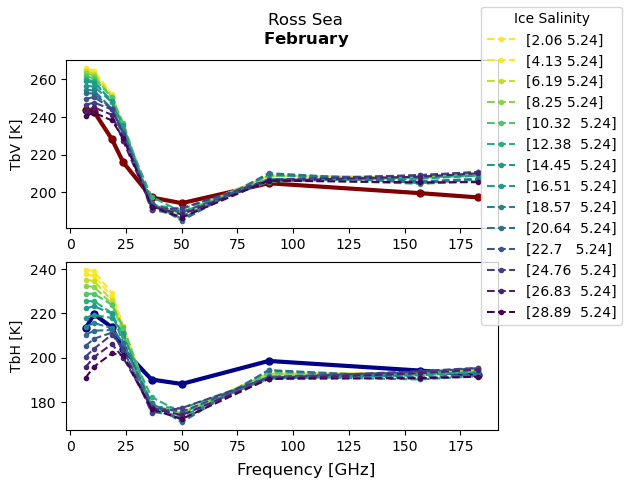

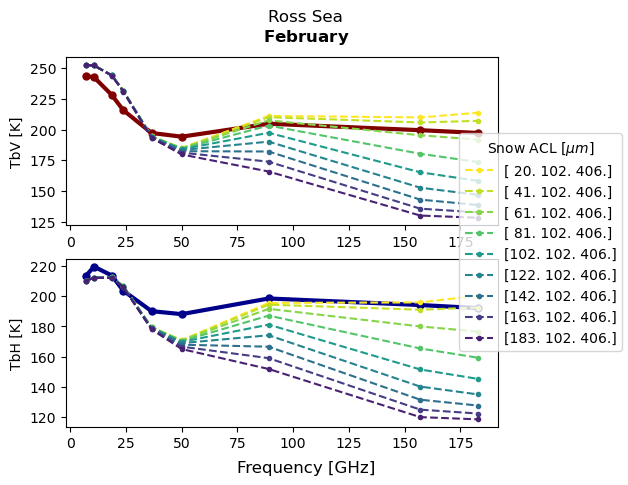

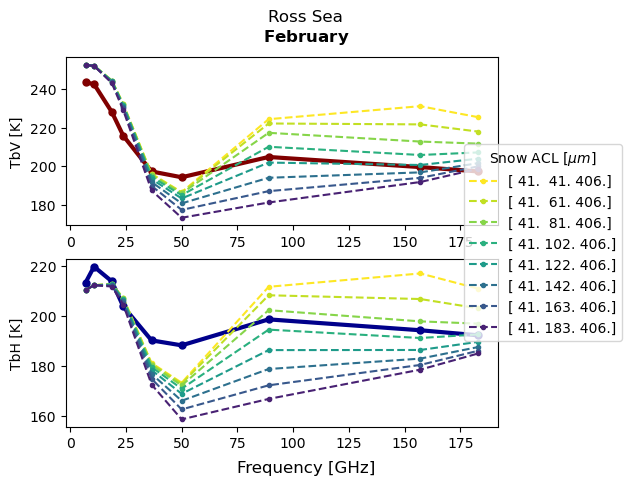

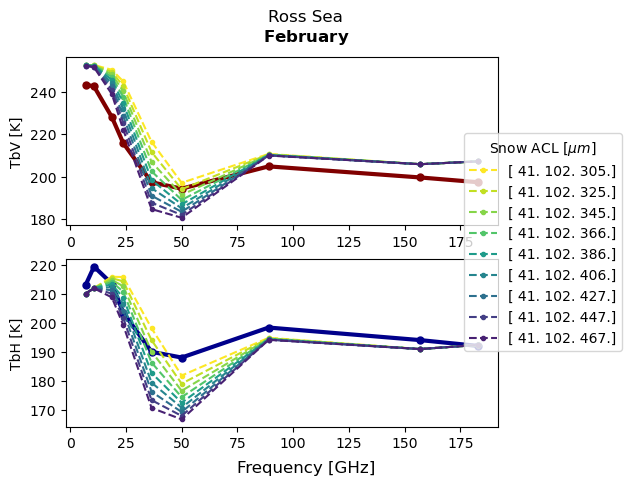

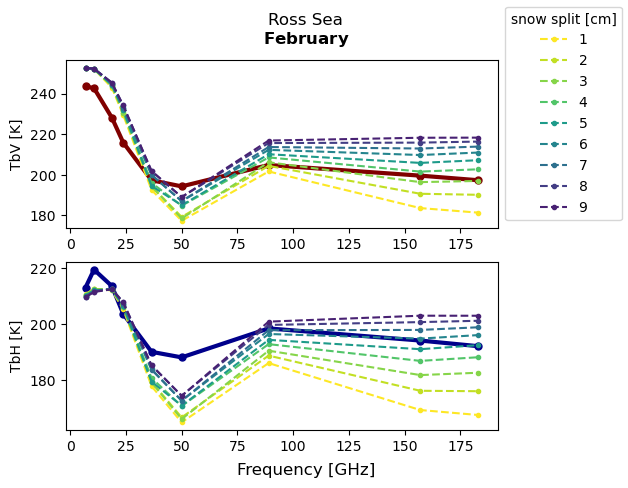

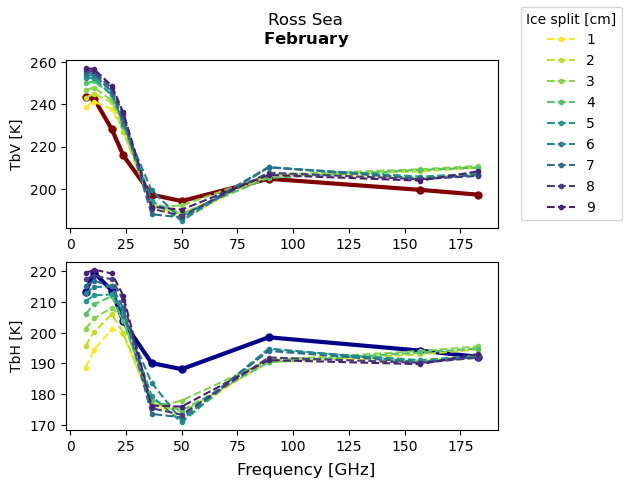

In [9]:
# forward_parameterUncertainty(Xb, freqs, m, radiometer, logMask = False, setting = 1,  ACL_factors=[0.2, 0.5, 2], 
#                       ice_split=5, ice_sal_factors = [2, 1], snow_split_low=5, snow_density_up=250)
setting = 5


# The simulation starts the 1st october. I skip the first 200 iterations, meaning that I skip 50 days. Then i am in the 20th November
month_separators=np.array(
         [   11,          42,        73,       101,     132,     162,    193,    223,    254,      285,         315,      346]) # This should equal the amount of days until the end of each month from the 20th november
months = ["November", "December", "January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]


for i in [1900]:
    viridis = cm.get_cmap('viridis', 12)
    # Define the parameters that we use in this iteration
    X_new = np.copy(X_matrix_ross[[0,1,2,3],i])
    Tb_true = np.copy(Y_matrix_ross[:, i])
    
    # Define the month we are in
    if i < 800:
        fig.set_facecolor("LightYellow")
        index = np.sum((month_separators-i/4) < 0)
        loc_month = ("Location A\n" + r"$\bf{"+months[index]+"}$")
    elif i < 1600:
        fig.set_facecolor("AliceBlue") # "Linen" if this doesn't work
        index = np.sum((month_separators-(i-800)/4) < 0)
        loc_month = ("Location B\n" + r"$\bf{"+months[index]+"}$")
    else:
        fig.set_facecolor("LavenderBlush") # "WhiteSmoke" if this doesn't work
        index = np.sum((month_separators-(i-1600)/4) < 0)
        loc_month = ("Ross Sea\n" + r"$\bf{"+months[index]+"}$")
    
    
    ### Define the new snow densities to be used
    density_list =250 + np.array([[ 100],
                                  [ 80],
                                  [ 60],
                                  [ 40],
                                  [ 20],
                                  [ 0],
                                  [ 20],
                                  [-40],
                                  [-60],
                                  [-80],
                                  [-100]]) 
    fig, ax = plt.subplots(nrows=2)
    ax[0].plot(freqs*1e-9, Tb_true[::2], '.-', color='Maroon', linewidth=3, markersize=10)
    ax[1].plot(freqs*1e-9, Tb_true[1::2], '.-', color='DarkBlue', linewidth=3, markersize=10)
    for j in range(density_list.shape[0]): 
        # Define the Tb from function with density offset
        Tb_model_new = forward_parameterUncertainty(X_new, 
                                                    freqs, 
                                                    m,
                                                    radiometer,
                                                    logMask = False,
                                                    setting=5,
                                                    snow_density_up=density_list[j])
        # Plot the results
        ax[0].plot(freqs*1e-9, Tb_model_new[::2], '.--',  color=viridis(1-j/density_list.shape[0]), label=f"{np.round(density_list[j],2)}")
        ax[1].plot(freqs*1e-9, Tb_model_new[1::2], '.--', color=viridis(1-j/density_list.shape[0]))
    fig.legend(title='New Snow Density [kg/m^3]')
    ax[0].set_ylabel('TbV [K]')
    ax[1].set_ylabel('TbH [K]')
    fig.supxlabel('Frequency [GHz]')
    fig.subplots_adjust(right=0.8)
    fig.suptitle(loc_month)
    
    
    ### Define the salinity factors to be used
    ice_sal_factors = np.array([[0.2, 1],
                                [0.4, 1],
                                [0.6, 1],
                                [0.8, 1],
                                [1.0, 1],
                                [1.2, 1],
                                [1.4, 1],
                                [1.6, 1],
                                [1.8, 1],
                                [2.0, 1],
                                [2.2, 1],
                                [2.4, 1],
                                [2.6, 1],
                                [2.8, 1]]) 
    fig, ax = plt.subplots(nrows=2)
    ax[0].plot(freqs*1e-9, Tb_true[::2], '.-', color='Maroon', linewidth=3, markersize=10)
    ax[1].plot(freqs*1e-9, Tb_true[1::2], '.-', color='DarkBlue', linewidth=3, markersize=10)
    for j in range(ice_sal_factors.shape[0]): 
        # Define the Tb from function with new salinities 
        Tb_model_new = forward_parameterUncertainty(X_new, 
                                                    freqs, 
                                                    m,
                                                    radiometer,
                                                    logMask = False,
                                                    setting=5,
                                                    ice_sal_factors=ice_sal_factors[j])
        # Since we want to write proper salinities in legend, the salinities have to be extracted.
        num, di, Ti, Wi, roi, pci, Sal, _, si = smrt_profile(X_new[0], X_new[1], X_new[2], 'firstyear', snow_density_up=250)
        ice_salinities = np.array([(Sal[si == 1])[0:5].mean(), (Sal[si == 1])[5:].mean()])
        ax[0].plot(freqs*1e-9, Tb_model_new[::2], '.--',  color=viridis(1-j/ice_sal_factors.shape[0]), label=f"{np.round(ice_salinities*ice_sal_factors[j],2)}")
        ax[1].plot(freqs*1e-9, Tb_model_new[1::2], '.--', color=viridis(1-j/ice_sal_factors.shape[0]))
    fig.legend(title='Ice Salinity')
    ax[0].set_ylabel('TbV [K]')
    ax[1].set_ylabel('TbH [K]')
    fig.supxlabel('Frequency [GHz]')
    fig.subplots_adjust(right=0.8)
    fig.suptitle(loc_month)
    
    
    ### Define the ACL factors to be used
    ACL_factor_list_tuple = (np.array([[0.1, 0.5, 2.0],
                                      [0.2, 0.5, 2.0],
                                      [0.3, 0.5, 2.0],
                                      [0.4, 0.5, 2.0],
                                      [0.5, 0.5, 2.0],
                                      [0.6, 0.5, 2.0],
                                      [0.7, 0.5, 2.0],
                                      [0.8, 0.5, 2.0],
                                      [0.9, 0.5, 2.0]]),
                            np.array([[0.2, 0.2, 2.0],
                                      [0.2, 0.3, 2.0],
                                      [0.2, 0.4, 2.0],
                                      [0.2, 0.5, 2.0],
                                      [0.2, 0.6, 2.0],
                                      [0.2, 0.7, 2.0],
                                      [0.2, 0.8, 2.0],
                                      [0.2, 0.9, 2.0]]),
                            np.array([[0.2, 0.5, 1.5],
                                      [0.2, 0.5, 1.6],
                                      [0.2, 0.5, 1.7],
                                      [0.2, 0.5, 1.8],
                                      [0.2, 0.5, 1.9],
                                      [0.2, 0.5, 2.0],
                                      [0.2, 0.5, 2.1],
                                      [0.2, 0.5, 2.2],
                                      [0.2, 0.5, 2.3]]))
    for j in range(3):
        fig, ax = plt.subplots(nrows=2)
        ACL_factor_list = ACL_factor_list_tuple[j]
        ax[0].plot(freqs*1e-9, Tb_true[::2], '.-', color='Maroon', linewidth=3, markersize=10)
        ax[1].plot(freqs*1e-9, Tb_true[1::2], '.-', color='DarkBlue', linewidth=3, markersize=10)
        for k in range(ACL_factor_list.shape[0]):
            # Define the Tb from function with new salinities 
            Tb_model_new = forward_parameterUncertainty(X_new, 
                                                        freqs, 
                                                        m,
                                                        radiometer,
                                                        logMask = False,
                                                        setting=5,
                                                        ACL_factors=ACL_factor_list[k])
            ax[0].plot(freqs*1e-9, Tb_model_new[::2], '.--',  color=viridis(1-k/ACL_factor_list.shape[0]), label=f"{np.round(X_new[3]*ACL_factor_list[k]*1e6)}")
            ax[1].plot(freqs*1e-9, Tb_model_new[1::2], '.--', color=viridis(1-k/ACL_factor_list.shape[0]))
        fig.legend(title='Snow ACL [$\mu m$]', loc='right') 
        fig.subplots_adjust(right=0.8)
        fig.suptitle(loc_month)
        ax[0].set_ylabel('TbV [K]')
        ax[1].set_ylabel('TbH [K]')
        fig.supxlabel('Frequency [GHz]')
    
    
    ### Define the snow_split parameters to be used
    snow_split_low_list = np.arange(1,10)
    
    fig, ax = plt.subplots(nrows=2)
    ax[0].plot(freqs*1e-9, Tb_true[::2], '.-', color='Maroon', linewidth=3, markersize=10)
    ax[1].plot(freqs*1e-9, Tb_true[1::2], '.-', color='DarkBlue', linewidth=3, markersize=10)
    for j in range(snow_split_low_list.shape[0]): 
        Tb_model_new = forward_parameterUncertainty(X_new, 
                                                    freqs, 
                                                    m,
                                                    radiometer,
                                                    logMask = False,
                                                    setting=5,
                                                    snow_split_low=snow_split_low_list[j])
        ax[0].plot(freqs*1e-9, Tb_model_new[::2], '.--',  color=viridis(1-j/snow_split_low_list.shape[0]), label=f"{snow_split_low_list[j]}")
        ax[1].plot(freqs*1e-9, Tb_model_new[1::2], '.--', color=viridis(1-j/snow_split_low_list.shape[0]))
    fig.legend(title='snow split [cm]')
    ax[0].set_ylabel('TbV [K]')
    ax[1].set_ylabel('TbH [K]')
    fig.supxlabel('Frequency [GHz]')
    fig.subplots_adjust(right=0.8)
    fig.suptitle(loc_month)
    
     ### Define the ice_split parameters to be used
    ice_split_list = np.arange(1,10)
    
    fig, ax = plt.subplots(nrows=2)
    ax[0].plot(freqs*1e-9, Tb_true[::2], '.-', color='Maroon', linewidth=3, markersize=10)
    ax[1].plot(freqs*1e-9, Tb_true[1::2], '.-', color='DarkBlue', linewidth=3, markersize=10)
    for j in range(snow_split_low_list.shape[0]): 
        Tb_model_new = forward_parameterUncertainty(X_new, 
                                                    freqs, 
                                                    m,
                                                    radiometer,
                                                    logMask = False,
                                                    setting=5,
                                                    ice_split=ice_split_list[j])
        ax[0].plot(freqs*1e-9, Tb_model_new[::2], '.--',  color=viridis(1-j/ice_split_list.shape[0]), label=f"{ice_split_list[j]}")
        ax[1].plot(freqs*1e-9, Tb_model_new[1::2], '.--', color=viridis(1-j/ice_split_list.shape[0]))
    fig.legend(title='Ice split [cm]')
    ax[0].set_ylabel('TbV [K]')
    ax[1].set_ylabel('TbH [K]')
    fig.supxlabel('Frequency [GHz]')
    fig.subplots_adjust(right=0.8)
    fig.suptitle(loc_month)
    
    

Because I felt that me arbitrarily picking iterations from across sites and testing my function with the linear map wasn't very representative of the whole dataset, I created a gif of the overall fit of my function, based on the parameters from the MEMLS simulation. My overall goal with this gif was to see whether or not my model had any tendencies to overstimate/underestimate certain frequency channels. The following code section creates the gif and displays it. I made an if statement so that you dont have to create the gif everytime you run the code. This section will overwrite the pictures everytime it is run so i recommend you keep the the if-statement False. If you run into any model crashes, then you can add to the crash index.

In [10]:
# The simulation starts the 1st october. I skip the first 200 iterations, meaning that I skip 50 days. Then i am in the 20th November
months = ["November", "December", "January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]
month_separators=[   11,        42,        73,       101,     132,     162,    193,    223,    254,      285,         315,      346] # This should equal the amount of days until the end of each month from the 20th november
setting=5
create_gif_frames = False



frames = []
for i in np.arange(0, Y_matrix_ross.shape[1], 5):
    if any(i == [275, 280, 1955, 2330]): # CRASH INDEX: This is to avoid model crashes. I think crash happens due to outlier measurements of salinity or ACL measurements.
        continue
    print(i)
    if create_gif_frames==True: # This if-statement is only here in case you want to change the fps after gif has been created. 
        # Initialize the parameters
        Tb_true = Y_matrix_ross[:, i] # The true solution
        X_new = X_matrix_ross[:,i]

        fig, ax = plt.subplots(nrows=2, sharex=True)
        ax[0].plot(freqs*1e-9, Tb_true[::2], '.-', color='Maroon', linewidth=3, markersize=10, label='True')
        ax[1].plot(freqs*1e-9, Tb_true[1::2], '.-', color='Maroon', linewidth=3, markersize=10)
        ax[0].grid(); ax[1].grid()
        ax[0].set_ylim([150, 260]); ax[1].set_ylim([140, 225])
        ax[0].set_ylabel('V'); ax[1].set_ylabel('H')
        ax[1].set_xlabel('Frequency [GHz]')
        fig.supylabel('Brightness Temp [K]')
        viridis = cm.get_cmap('viridis', 12)
        # Define the prediction based on true parameters
        if any(setting==np.array([3,5])):
            Tb_model_new = forward_parameterUncertainty(X_new[0:4], freqs, m, radiometer, setting=setting)
        else:
            Tb_model_new = forward_parameterUncertainty(X_new, freqs, m, radiometer, setting=setting)
        ax[0].plot(freqs*1e-9, Tb_model_new[::2], '.--',  color=viridis(1), label='Prediction')
        ax[1].plot(freqs*1e-9, Tb_model_new[1::2], '.--', color=viridis(1))
        fig.legend()

        if i < 800:
            fig.set_facecolor("LightYellow")
            index = np.sum((month_separators-i/4) < 0)
            fig.suptitle("Location A\n" + r"$\bf{"+months[index]+"}$")
        elif i < 1600:
            fig.set_facecolor("AliceBlue") # "Linen" if this doesn't work
            index = np.sum((month_separators-(i-800)/4) < 0)
            fig.suptitle("Location B\n" + r"$\bf{"+months[index]+"}$")
        else:
            fig.set_facecolor("LavenderBlush") # "WhiteSmoke" if this doesn't work
            index = np.sum((month_separators-(i-1600)/4) < 0)
            fig.suptitle("Ross Sea\n" + r"$\bf{"+months[index]+"}$")

        plt.savefig(f"gif_frames/start_guess{i}.png")
        plt.close('all')

    # Load the images into the the frames array
    image = imageio.v2.imread(f"gif_frames/start_guess{i}.png")
    frames.append(image)
# Save the images as a gif
imageio.mimsave(f"SMRT_fit_with_Ross.gif",   # output gif
                frames,                         # array of input frames
                fps = 7)                        # optional: frames per second





0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
The model crashed
thickness_snow = [0.05 0.33 0.34] m 
temp_snow = [267.6 268.5 270.1] K
density_snow = [259. 319. 330.] kg/m3
ACL_snow = [ 32.  81. 323.] micron
ice_thickness = [0.05 0.5 ] m
ice_temp = [271. 271.]
ice_density = [926. 926.] kg/m3
ice_ACL = [100. 100.] micron
ice_sal = [21.  5.]
280
The model crashed
thickness_snow = [0.05 0.33 0.34] m 
temp_snow = [267.3 268.3 270. ] K
density_snow = [259. 319. 330.] kg/m3
ACL_snow = [ 33.  83. 331.] micron
ice_thickness = [0.05 0.51] m
ice_temp = [271. 271.]
ice_density = [926. 926.] kg/m3
ice_ACL = [100. 100.] micron
ice_sal = [21.  5.]
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
53

Now the optimal estimation convergence based on this forward model construction can be researched. In the code section below, you can alter the parameters "grindsetting", "setting", "cov_setup" or "y_cov_setup". They alter the way that the model is being processed within optimal estimation and they change the way that convergence is achieved. In the following list is the functionality of each of these parameters explained.
- grindseason: if grindseason=0, the code block will try and run optimal estimation on the measurement series. If grindseason=1, the results will be analyzed.
- Setting: Changing the setting changes the forward model. For more information about setting, see the markdown over the function definition. I suggest using setting 3 or 5.
- cov_setup: If cov_setup=0, the covariance matrix for the free parameters is created from all the 3 sites. If cov_setup=1, the covariance matrix for the free parameters is created only from site A+B.
- y_cov_setup: If y_cov_setup=0, the covariance matrix for the Tb is the identity matrix with a standard deviation of 10 K ($I\cdot 10^2$). If y_cov_setup=1, the covariance matrix for the Tb is created from the same measurements as the covariance matrix for free parameters. I suggest keeping y_cov_setup=0, as optimal estimation has a hard time converging otherwise.

If you want to calculate some data, I suggest you go down to the for-loop and start by running every 5th or 20th iteration. Just so that you can get a feel for how long it takes to run through all the 2400 measurement. The code is designed so that it saves everytime it finishes an iteration, so that you always can stop the program without losing all your progress. If you then want to finish the code later, you can do so and it will resume right where you left off. 
This means that if you make changes in the function, then you have to delete your old data. You can either do this manually or you can use the parameter "overwrite" to do so. 

The model succesfully converged in 84.3 % of the cases (2024/2400)
On average the model converges after 7.680335968379446 iterations of opt est
The mean abs residual is 7.263945490597535 for the Ross Sea
The mean abs residual is 7.687874682039506 across all sites


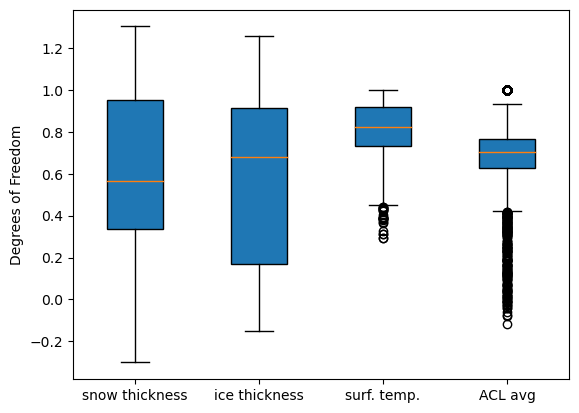

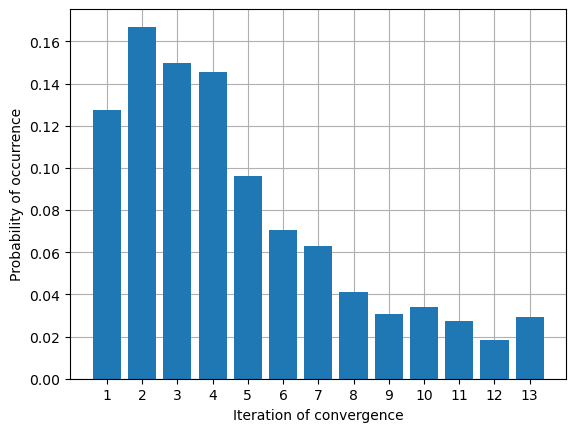

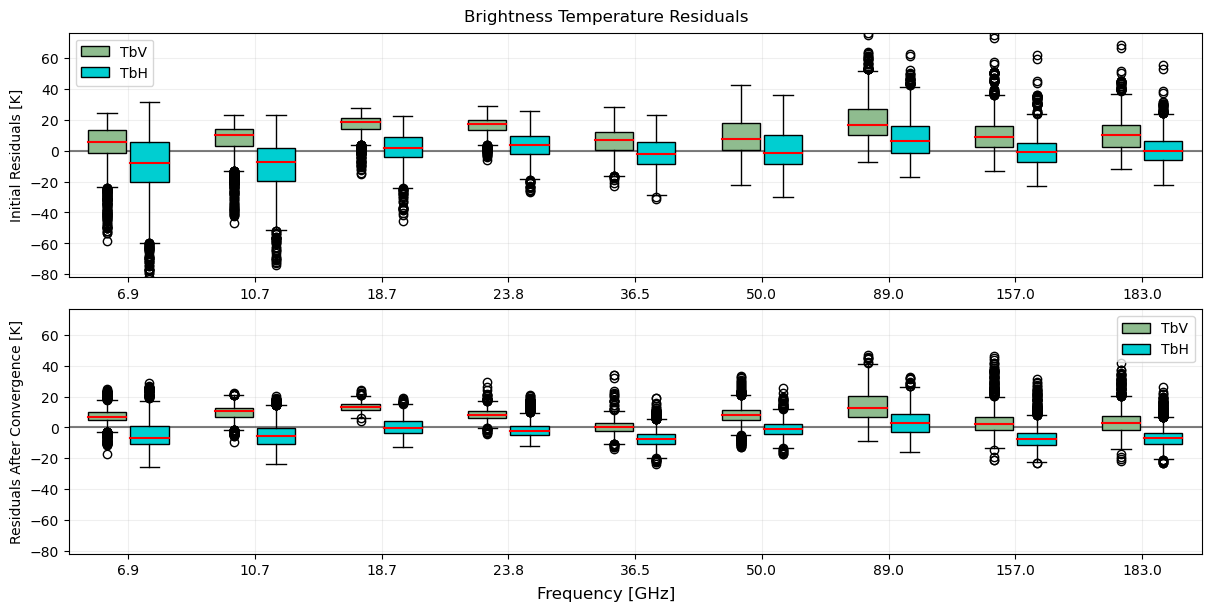

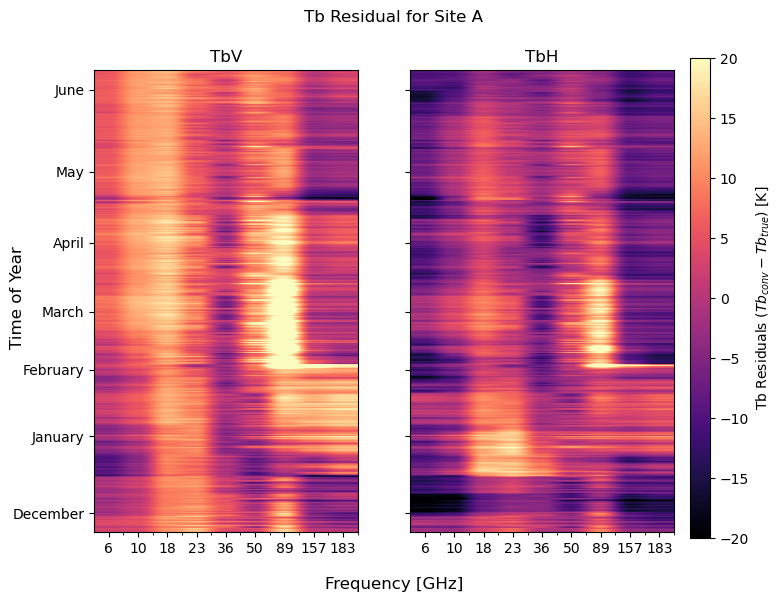

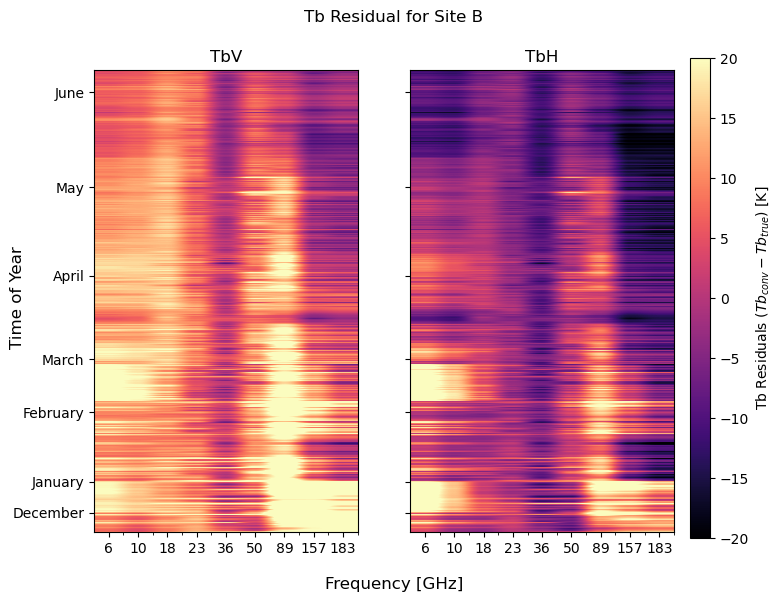

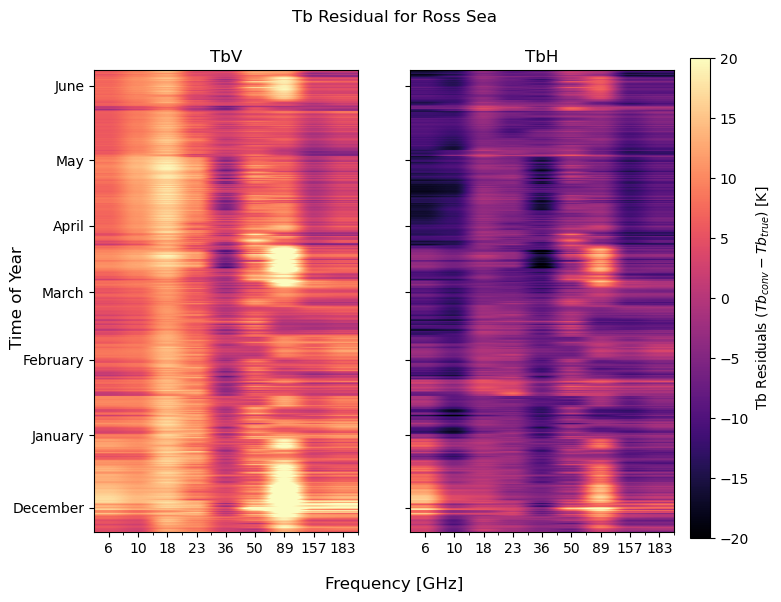

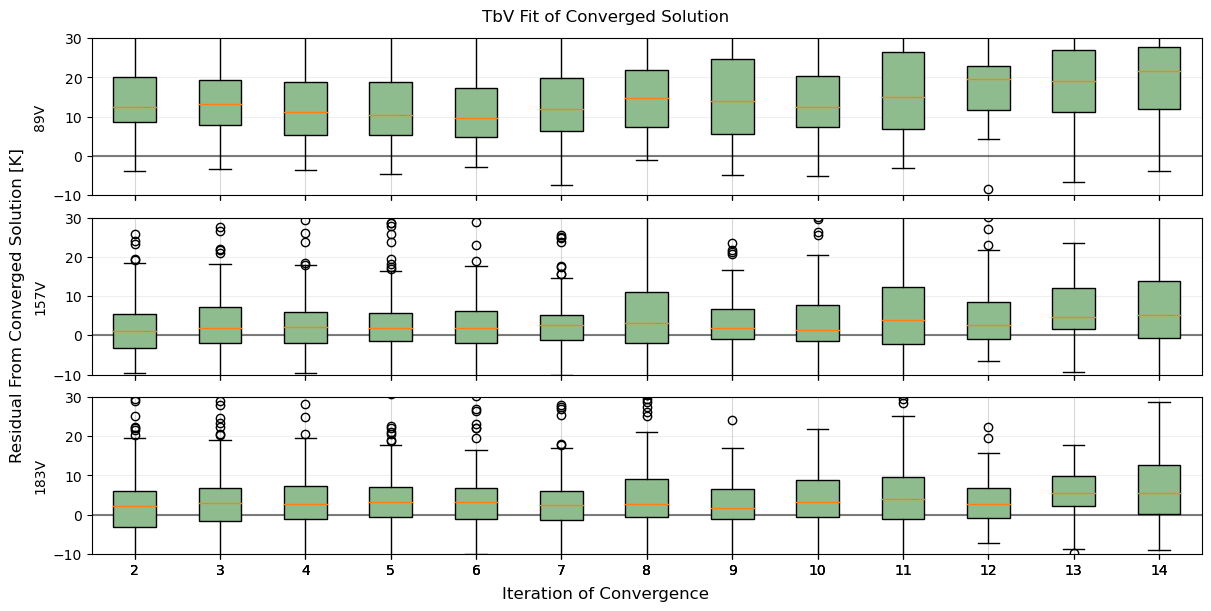

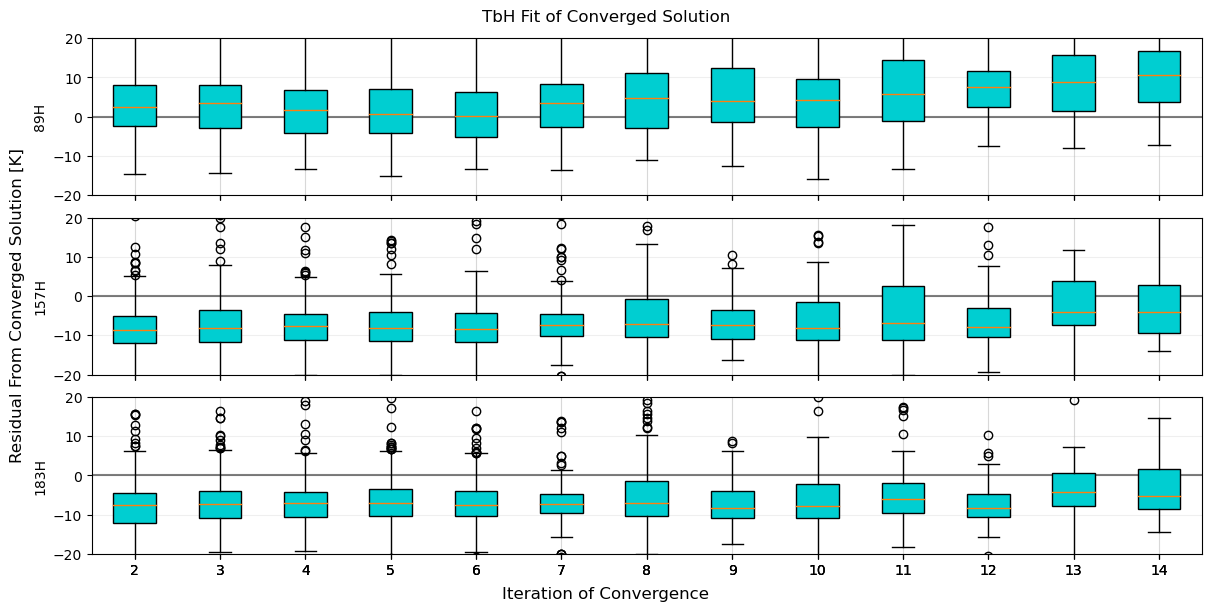

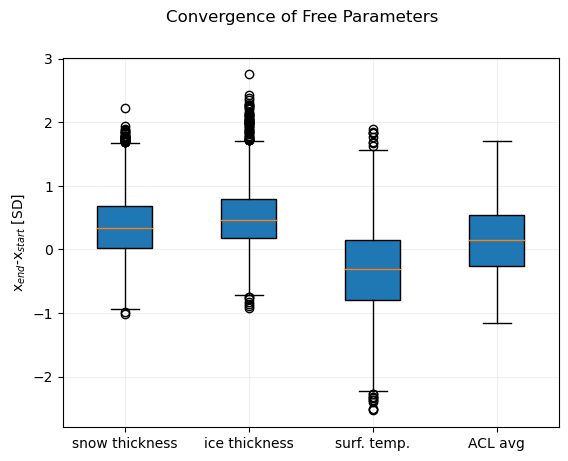

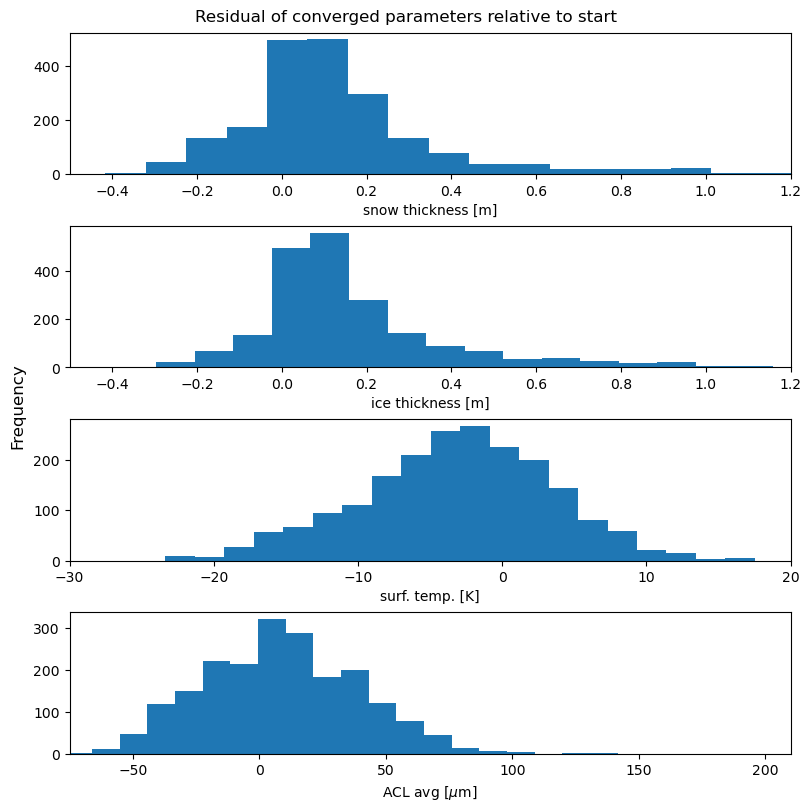

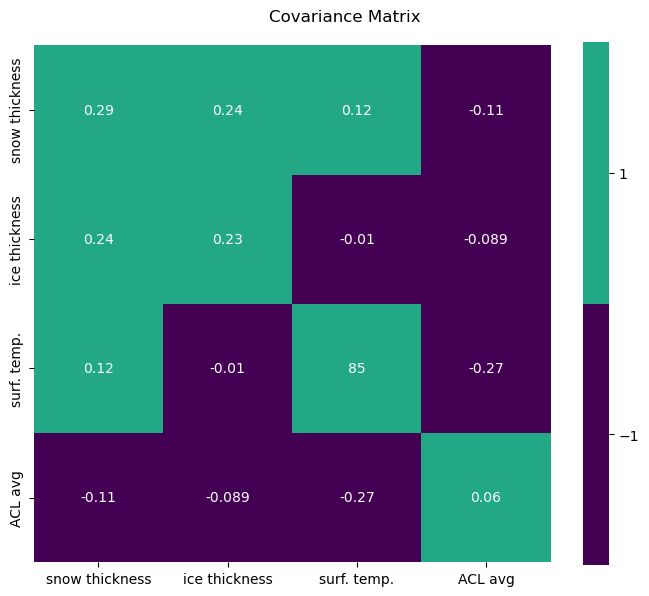

the following plots are generated from iteration 0


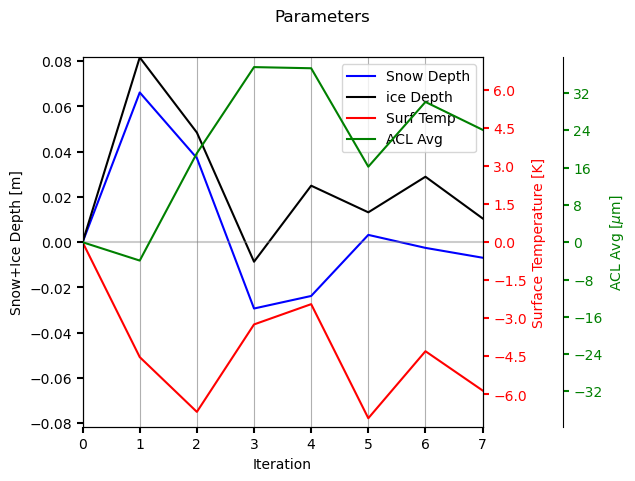

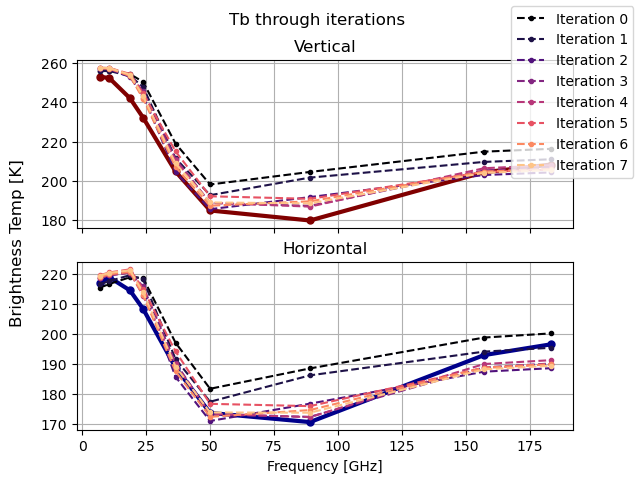

the following plots are generated from iteration 119


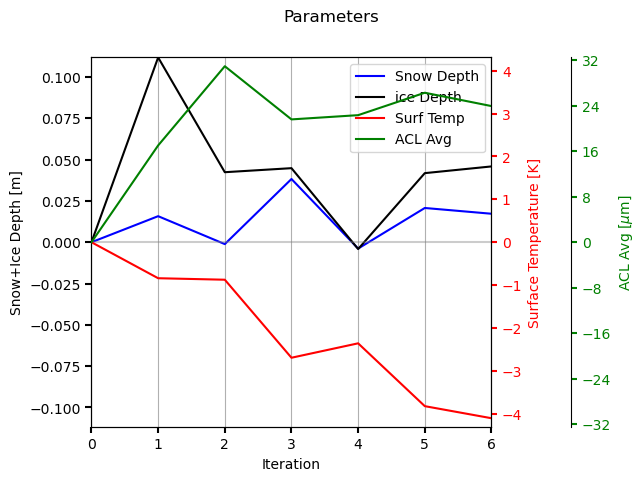

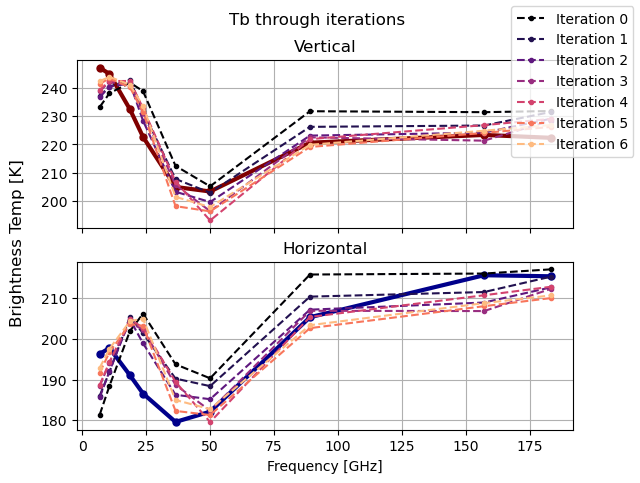

the following plots are generated from iteration 248


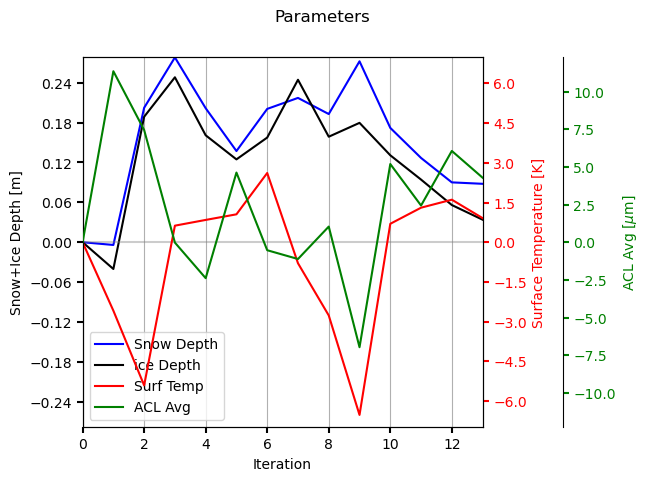

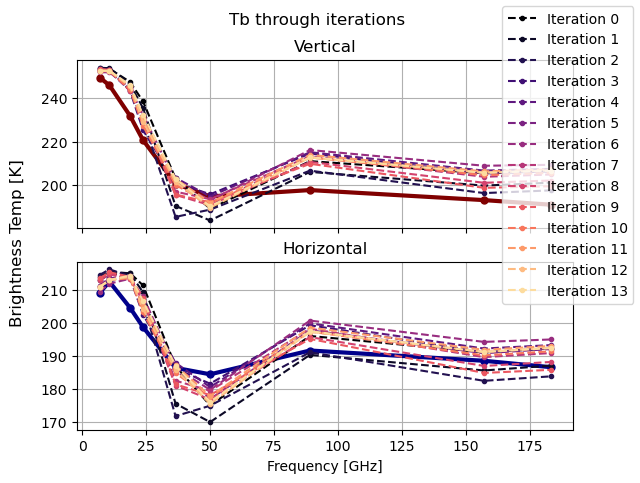

the following plots are generated from iteration 374


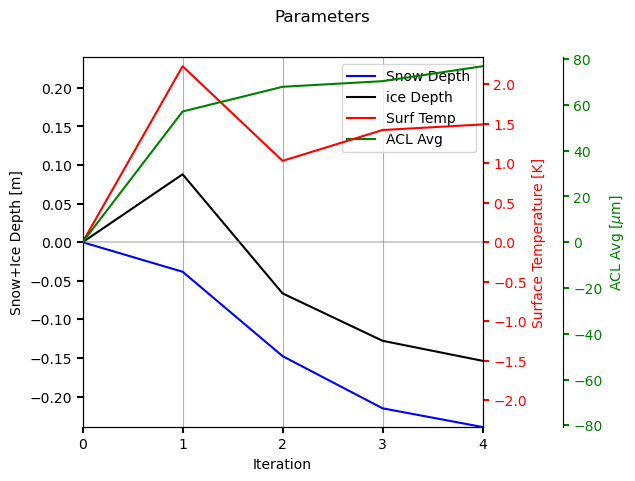

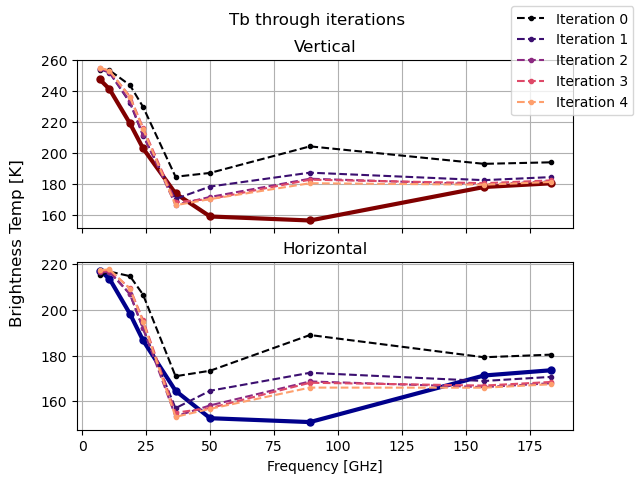

the following plots are generated from iteration 503


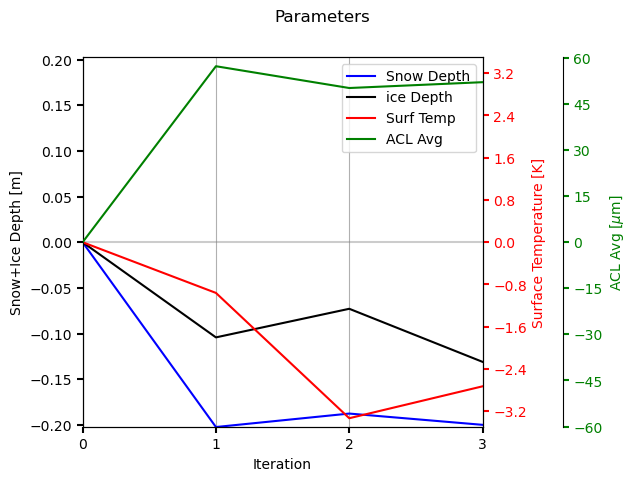

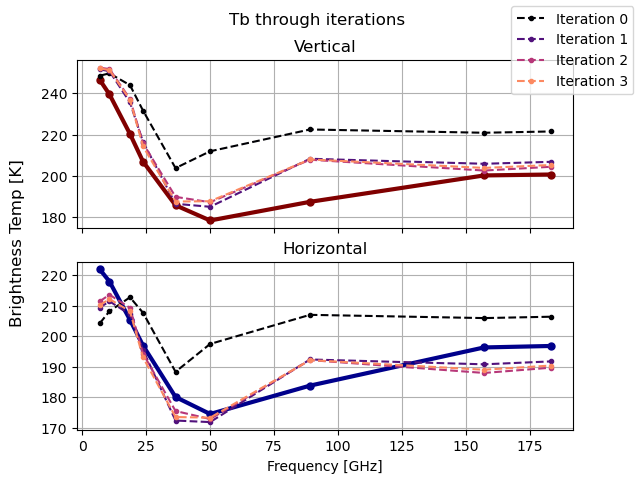

the following plots are generated from iteration 620


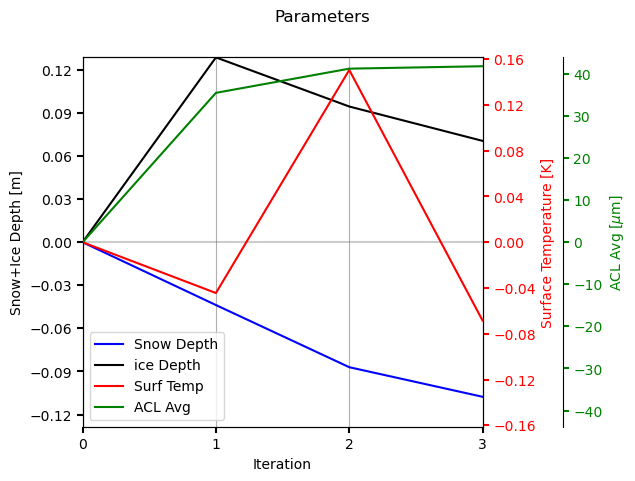

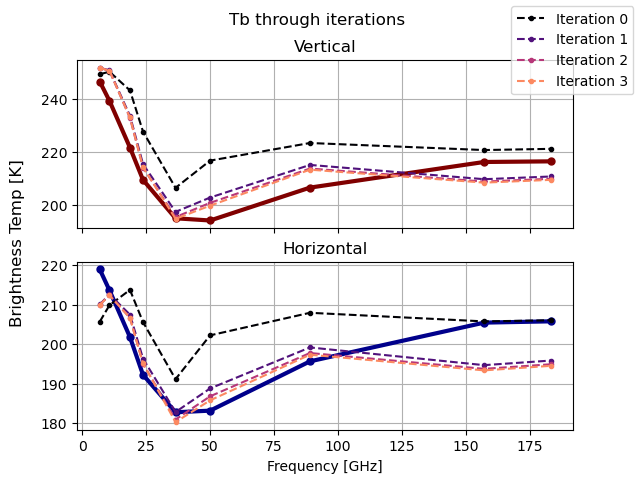

the following plots are generated from iteration 723


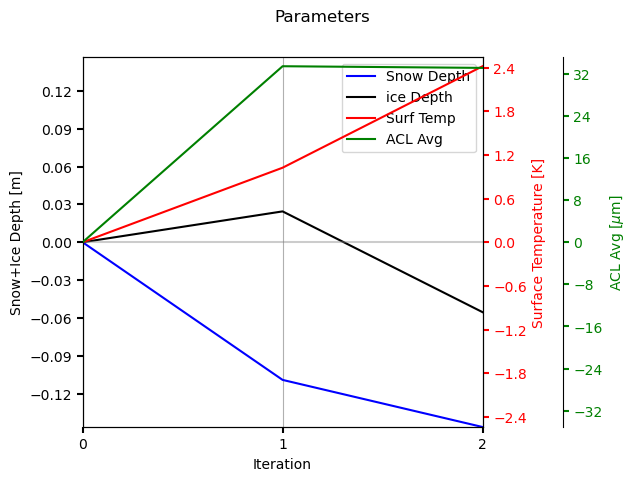

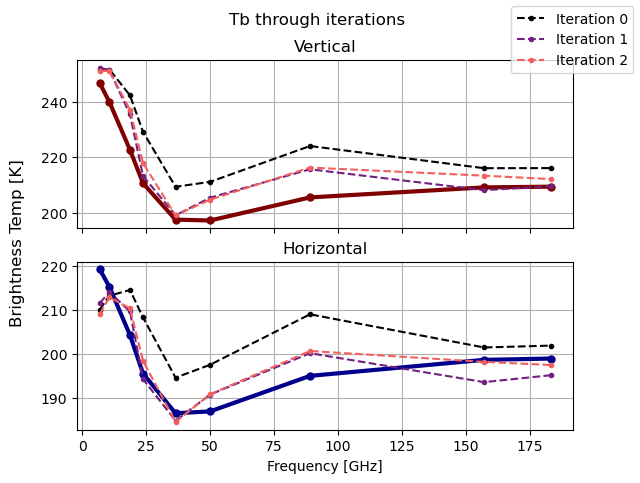

the following plots are generated from iteration 851


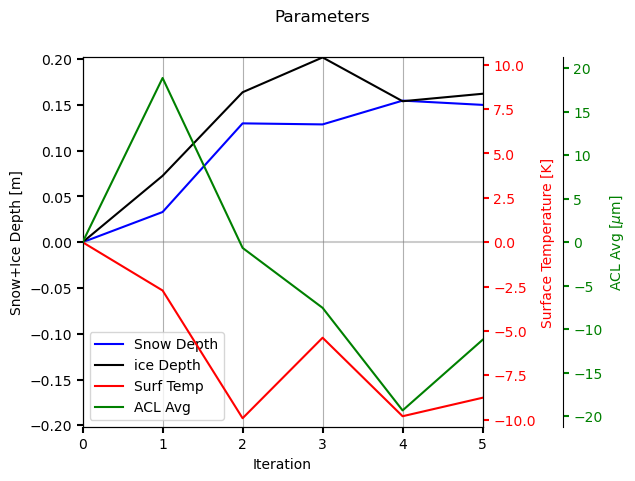

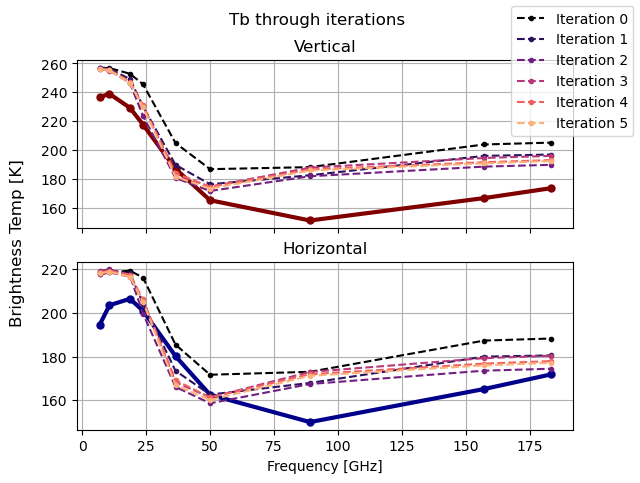

the following plots are generated from iteration 1050


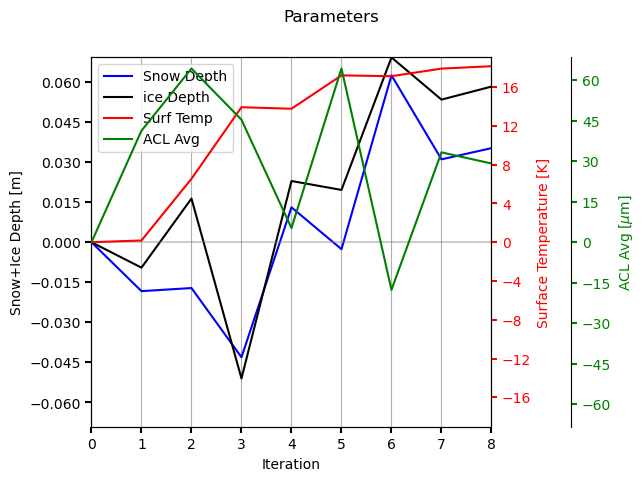

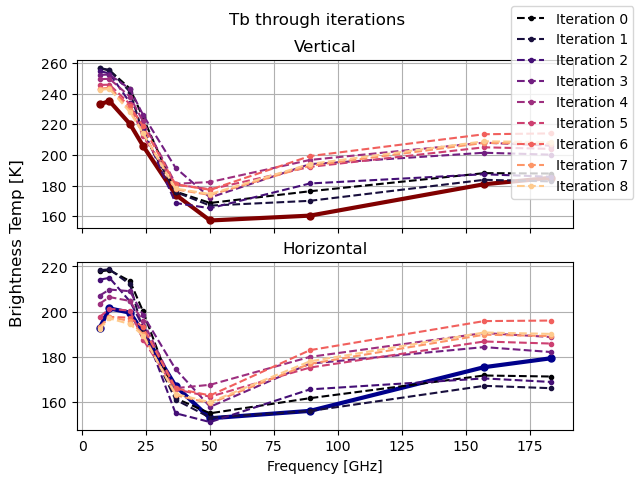

the following plots are generated from iteration 1208


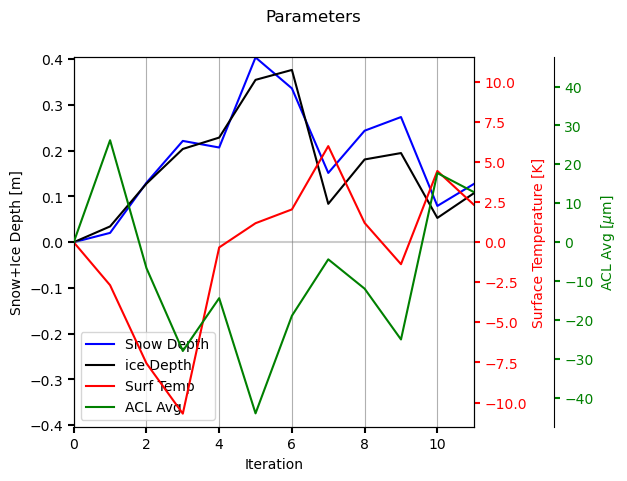

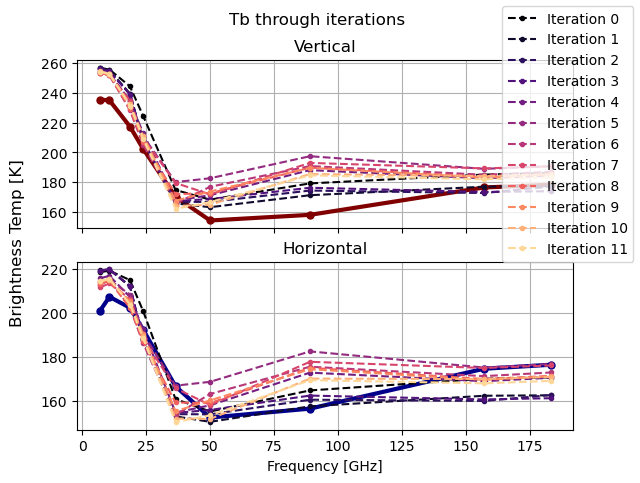

the following plots are generated from iteration 1323


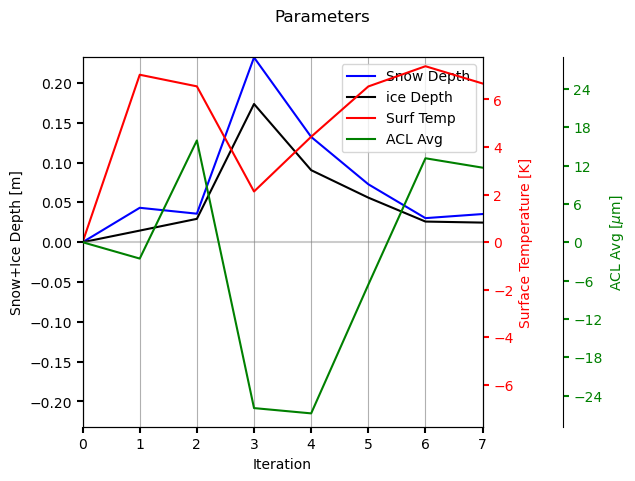

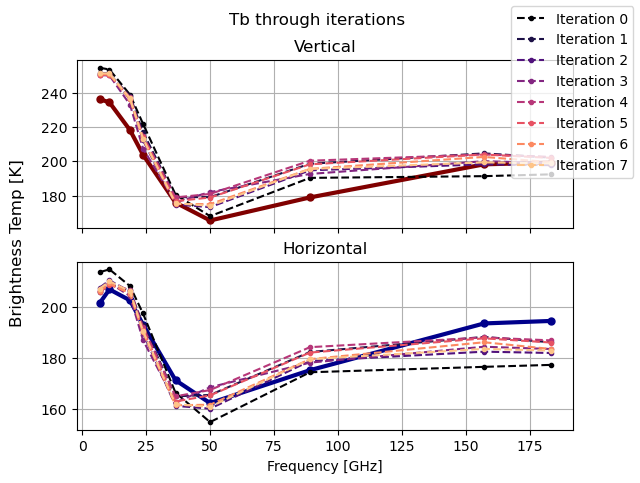

the following plots are generated from iteration 1431


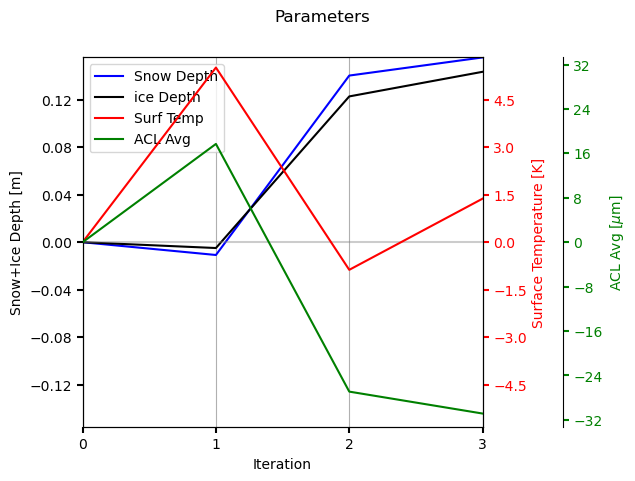

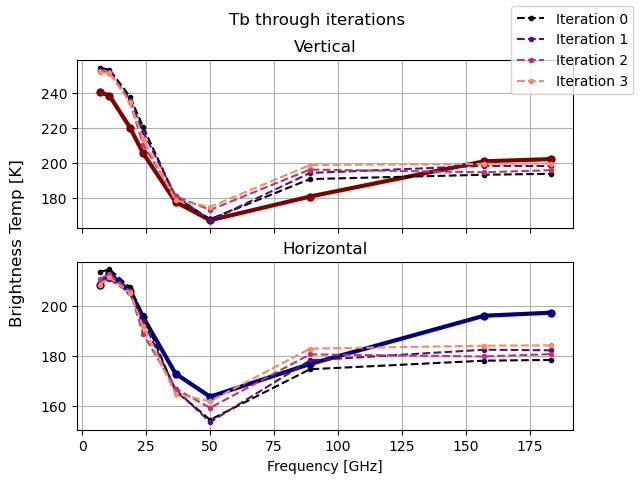

the following plots are generated from iteration 1534


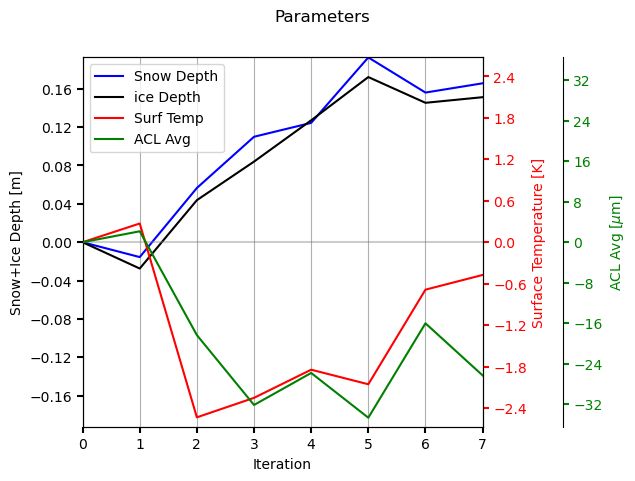

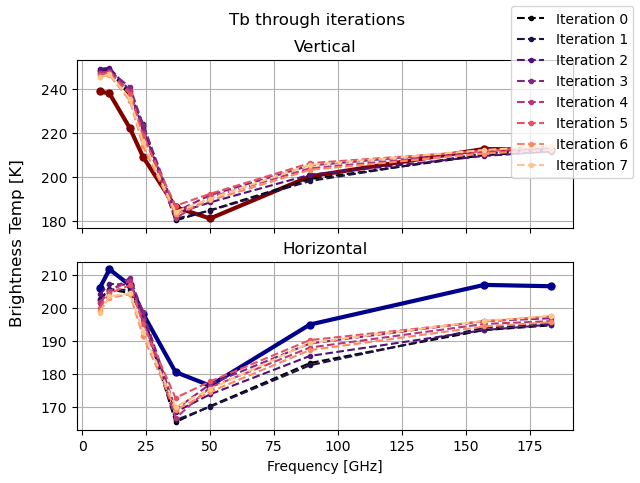

the following plots are generated from iteration 1634


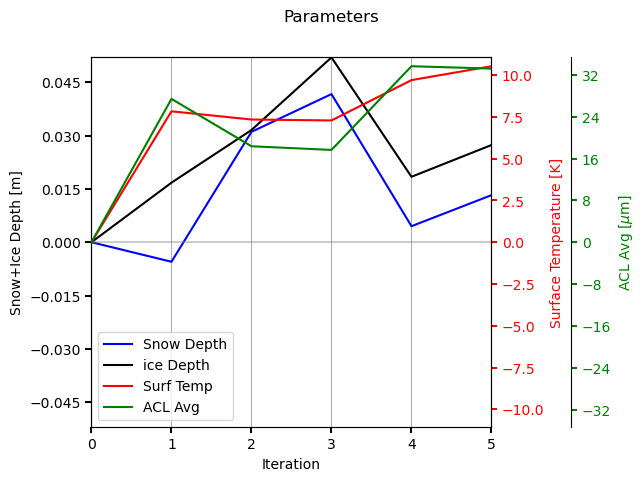

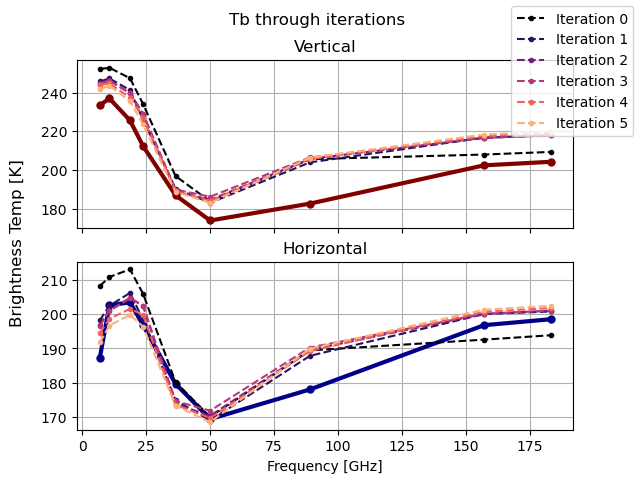

the following plots are generated from iteration 1741


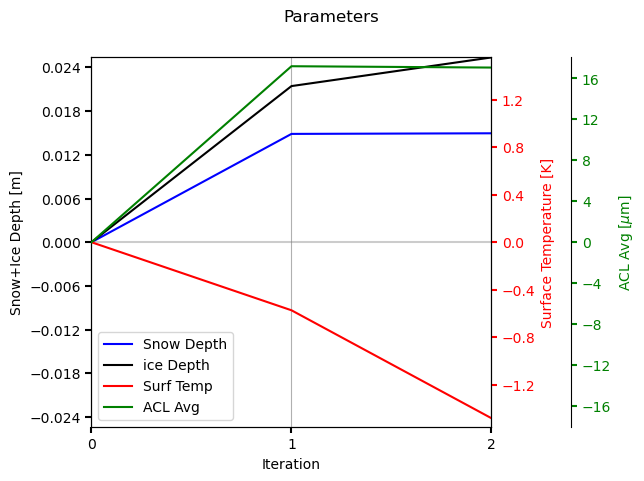

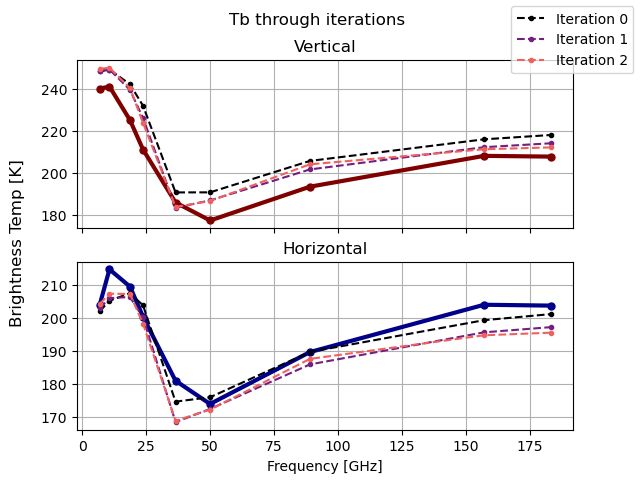

the following plots are generated from iteration 1842


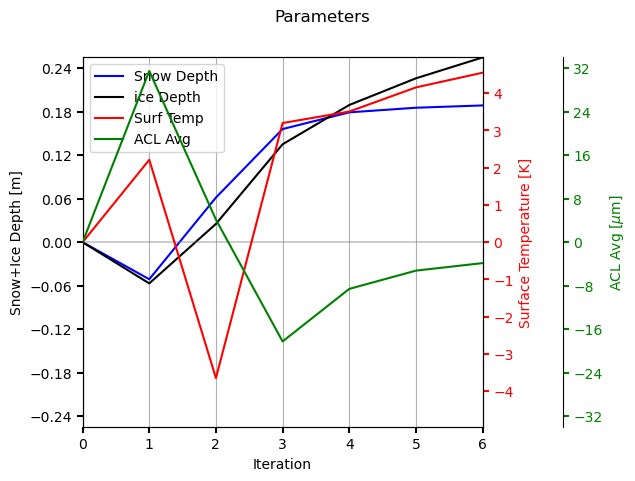

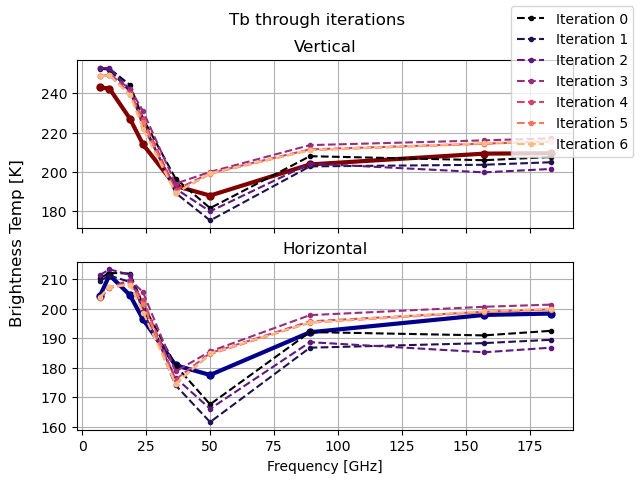

the following plots are generated from iteration 1943


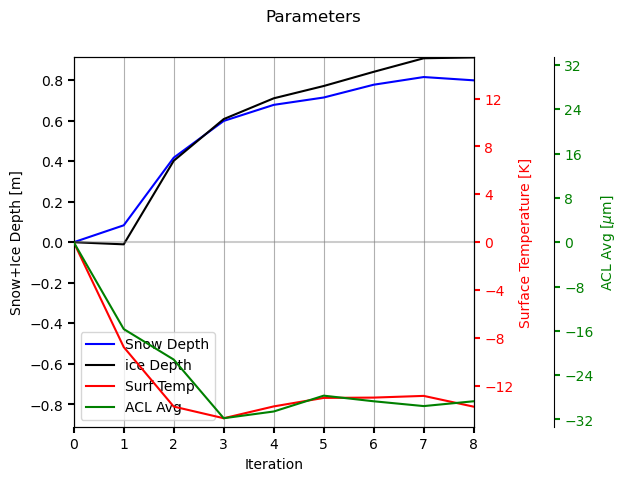

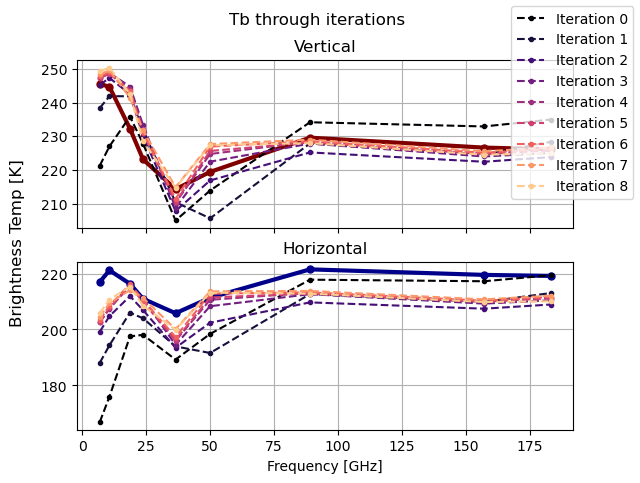

the following plots are generated from iteration 2047


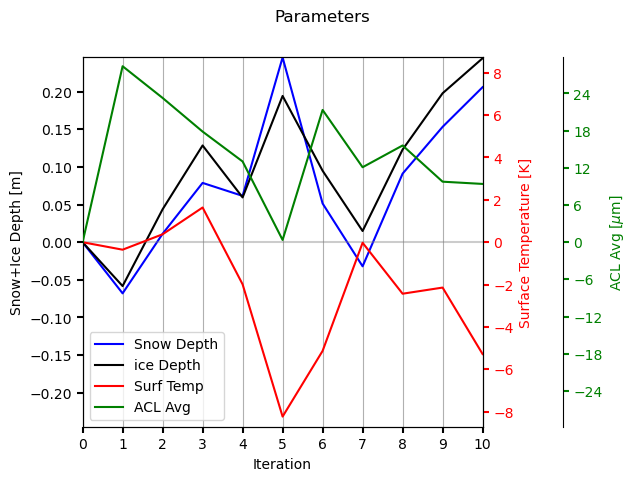

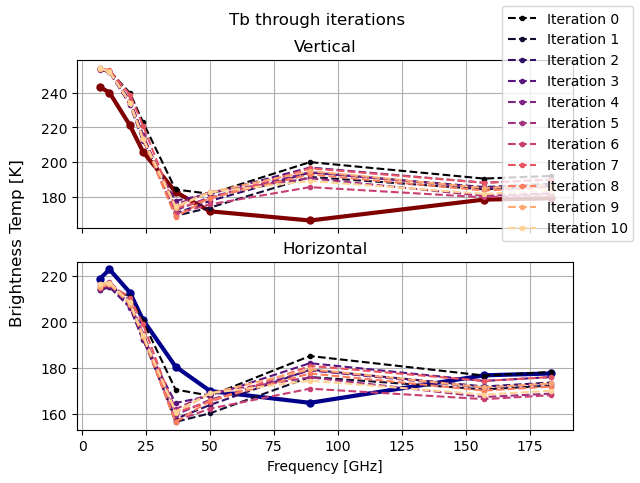

the following plots are generated from iteration 2165


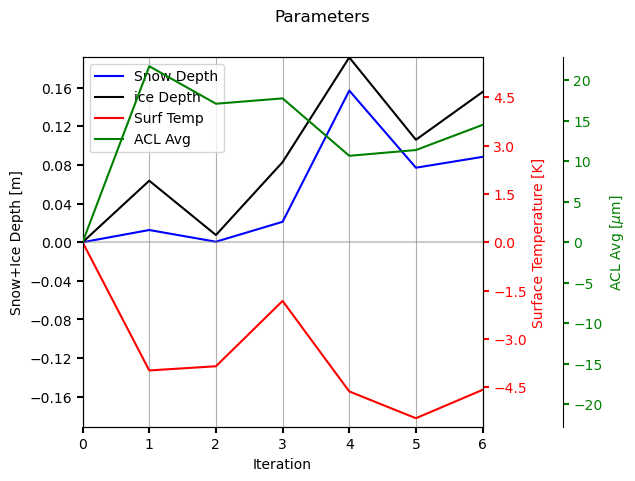

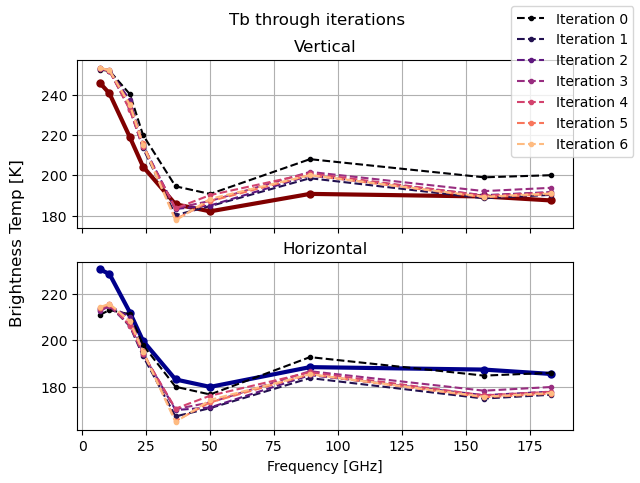

the following plots are generated from iteration 2273


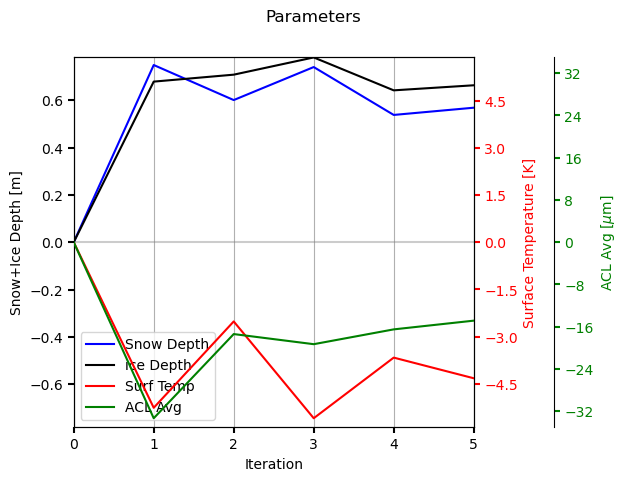

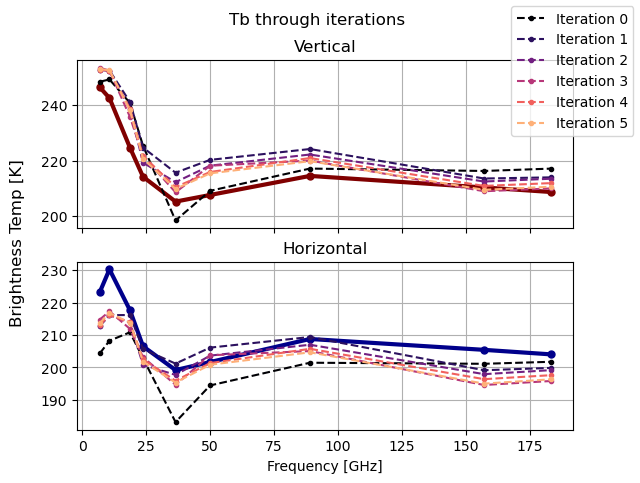

the following plots are generated from iteration 2373


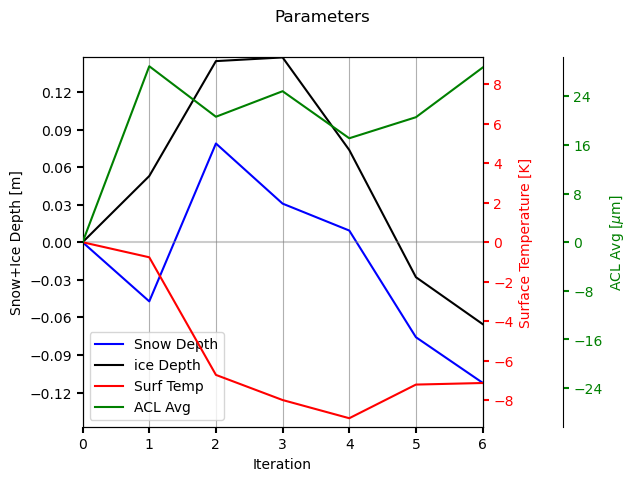

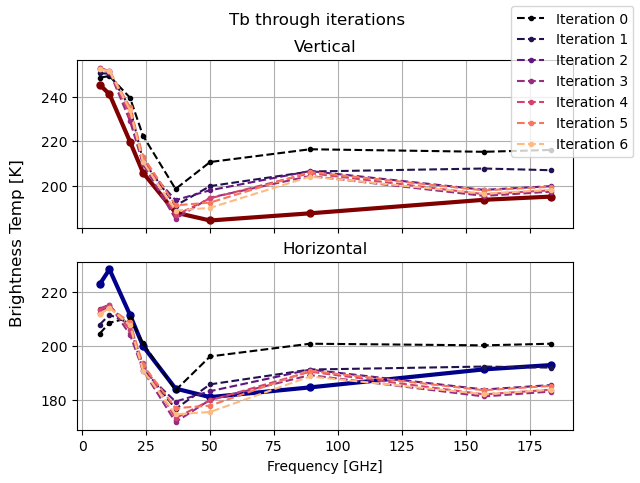

In [11]:
# load a start time to tell how long script takes to run
start = time.time()


################################################################################################################################################
grindSeason = 0 # Define whether the algorithm should grind for a solution or whether the grinded data should be analyzed
setting = 3 # Change setting to test different configurations for the uncertainties on the model parameters
cov_setup = 0 # A+B+Ross is used if 0. If 1, only A+B is used
y_cov_setup = 0 # If 0, the covariance for y is I*(10^2). If 1, the covariance is constructed from measurements.
################################################################################################################################################
overwrite = 0 # This is only important if grindSeason=1. It will make it so that if overwrite=1 then it overwrites what is in the current matrix
maxIter = 15 # This is important in order to define the matrix size, as well as run the mode

# Initialize some important parameters for opt est
x_vars = ['snow thickness', 'ice thickness', 'surf. temp.', 'ACL avg', 'ACL up']
y_cov = np.eye(Y_matrix.shape[0])*(10**2)
# change the covariance matrices to be defined from which measurements
if cov_setup==0:
    x_cov_model_uncertainty = np.cov(X_matrix_ross_t)
    if y_cov_setup==1:
        y_cov = np.cov(Y_matrix_ross)
elif cov_setup==1:
    x_cov_model_uncertainty = np.cov(X_matrix_t)
    if y_cov_setup==1:
        y_cov = np.cov(Y_matrix)
X_matrix_model_uncertainty = np.copy(X_matrix_ross_t)


if setting == 1:
    b_vars = [ "ACL_factor_high","ACL_factor_mid","ACL_factor_low","sal_ice_up"]
    b_p = [          0.2,                0.5,             2,             2     ]
    b_cov = (np.array([0.1,              0.1,            0.1,           0.2    ])**2)*np.eye(np.size(b_p))
elif setting == 2:
    b_vars = [ "ACL_factor_mid","ACL_factor_low","sal_ice_up"]
    b_p = [          0.5,             2,              2      ]
    b_cov = (np.array([0.1,          0.1,            0.1     ])**2)*np.eye(np.size(b_p))
elif setting == 3:
    x_vars = ['snow thickness', 'ice thickness', 'surf. temp.', 'ACL avg']
    logMask = (np.array([1,1,0,1]) == 1)
    X_matrix_model_uncertainty = np.copy(X_matrix_ross_t[0:4, :])
    x_cov_model_uncertainty = x_cov_model_uncertainty[0:4, 0:4]
    b_vars = [ "ACL_factor_high","ACL_factor_mid","ACL_factor_low","sal_ice_up","snow_density_up"]
    b_p = [          0.2,                0.5,            2,             2,              250      ]
    b_cov = (np.array([0.1,              0.1,            0.1,            0.1,            10      ])**2)*np.eye(np.size(b_p))
elif setting == 4:
    b_vars = [ "ACL_factor_high", "ACL_factor_mid", "ACL_factor_low", "sal_ice_up", "snow_density_up"]
    b_p = [            0.2,              0.5,             2,              2,                 250]
    b_cov = (np.array([0.1,              0.1,            0.1,            0.2,                10])**2)*np.eye(np.size(b_p))
elif setting == 5:
    x_vars = ['snow thickness', 'ice thickness', 'surf. temp.', 'ACL avg']
    logMask = (np.array([1,1,0,1]) == 1)
    X_matrix_model_uncertainty = np.copy(X_matrix_ross_t[0:4, :])
    x_cov_model_uncertainty = x_cov_model_uncertainty[0:4, 0:4]
    b_vars = []
    b_p = []
    b_cov = [[]]
elif setting == 6:
    # Same configuration as with setting 3, except the covariance matrix is altered for this setting. 
    x_vars = ['snow thickness', 'ice thickness', 'surf. temp.', 'ACL avg']
    logMask = (np.array([1,1,0,1]) == 1)
    X_matrix_model_uncertainty = np.copy(X_matrix_ross_t[0:4, :])
    x_cov_model_uncertainty = x_cov_model_uncertainty[0:4, 0:4]
    b_vars = [ "ACL_factor_high","ACL_factor_mid","ACL_factor_low","sal_ice_up","snow_density_up"]
    b_p = [          0.2,                0.5,            2,             2,              250      ]
    b_cov = (np.array([0.1,              0.2,            0.3,            0.1,            10      ])**2)*np.eye(np.size(b_p))



# Define the length of parameters
Nx = X_matrix_model_uncertainty.shape[0]

if grindSeason == 1:
    # Define the model with the correct setting for model uncertainties
    def forward(Xb):
        return forward_parameterUncertainty(Xb, freqs, m, radiometer, logMask=logMask, setting=setting)


    # Initialize a matrix that can save the results. The matrix will contain:
    # The index of the first dimension shows the iteration number of the 3 locations (like 0-799 is location 1, 800-1599 is location 2, etc...)
    # The 2nd dimension will contain different parameters. [0:Nx] - the parameters. [Nx: 2*Nx] - dgf per variable. [2*Nx:] - the brightness temperatures.
    # The 3rd dimension will hold values through iterations. Only parameters and brightness temperature have a value through iteration. dgf per variable is not continued through iterations
    try:
        if overwrite == 1:
            print("The matrix WILL be overwritten after the first loop!")
            raise UnboundLocalError('Overwrite is defined')
        matrix = np.load(f"{path}/data/model_uncertainty_setting_{setting}_{cov_setup}_{y_cov_setup}.npy")
    except:
        matrix = np.zeros((Y_matrix_ross.shape[1], 
                            Nx+Nx+Y_matrix_ross.shape[0], 
                            maxIter+2))
        matrix[:] = np.nan

    for i in np.arange(0, Y_matrix_ross.shape[1], 20):
        print(f"\ni = {i}")
        if ~np.isnan(matrix[i, 0, 0]) == 1:
            print("Skipping this iteration as it has already been run")
            continue
        # set a random seed so that answers are reproducible and start a loop timer
        np.random.seed(i)
        start_loop = time.time() # time to see how long each loop will take


        # Load the brightness temperatures we're aiming for in this iteration 
        Tb_goal = np.copy(Y_matrix_ross[:,i]) # can be applied to both the ross and the normal datasets 
        x_true = np.copy(X_matrix_model_uncertainty[:,i])  # can be applied to both the ross and the normal datasets
        x_ap = x_true 

        # Show that a solution is attempted
        matrix[i, :, 0] = np.ones(matrix.shape[1])

        # Run the optimal estimation
        oe = pyOE.optimalEstimation( 
            x_vars, 
            x_ap, 
            x_cov_model_uncertainty, 
            y_vars, 
            Tb_goal, 
            y_cov, 
            forward,
            b_vars = b_vars,
            b_p = b_p,
            S_b = b_cov,
            x_upperLimit = {"surface temperature": 270},
            convergenceTest='auto'
        ) 
        oe.doRetrieval(maxIter=maxIter)
        
        if oe.converged==True:
            matrix[i, 0:Nx, 0:oe.convI+2] = np.array(oe.x_i).T
            matrix[i, Nx:2*Nx, 0] = oe.dgf_x
            matrix[i, 2*Nx:, 0:oe.convI+2] = np.array(oe.y_i).T
            # print(matrix[i, 0, :])

        np.save(f"{path}/data/model_uncertainty_setting_{setting}_{cov_setup}_{y_cov_setup}.npy", matrix)




##################################################################################################################################################
# ANALYSIS
##################################################################################################################################################

if grindSeason == 0:
    # Create a function to be used when plotting the parameters through iterations
    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)
    
    matrix = np.load(f"{path}/data/model_uncertainty_setting_{setting}_{cov_setup}_{y_cov_setup}.npy")

    it_index = ~np.isnan(matrix[:,0,0]) # Start by finding a mask that shows where solutions were attempted
    it_number = np.arange(0, Y_matrix_ross.shape[1])[it_index] # Then show which iterations the solutions were attempted on
    convergence_index = ~np.isnan(matrix[it_index, 0, 1]) # From the attempts, remove the indices showing failed attempts at a solution
    it_number_converged = it_number[convergence_index] # From the convergence_index find the iteration numbers were solutions were found.
    
    # Find out what the convergence rate for this model setup was
    convergence_rate = np.sum(convergence_index)/np.sum(it_index)
    print(f"The model succesfully converged in {np.round(convergence_rate*100,1)} % of the cases ({np.sum(convergence_index)}/{np.sum(it_index)})")

    ### Illustrate the degress of freedom each variable has ### 
    plt.figure()
    plt.boxplot(matrix[it_index, Nx:2*Nx, 0], patch_artist=True)
    plt.xticks(np.arange(Nx)+1, x_vars)
    plt.ylabel("Degrees of Freedom")
    
    

    # The Tb residuals before any iterations of opt. est.
    r_initial = np.copy(matrix[it_number_converged, 2*Nx:, 0])-np.copy(Y_matrix_ross[:, it_number_converged]).T
    # The Tb residuals with the converged solution from opt est
    convI = np.sum(~np.isnan(matrix[it_number_converged, 0, :]), axis=1)
    r_last = np.copy(matrix[it_number_converged, 2*Nx:, convI-1])-Y_matrix_ross[:, it_number_converged].T

    print(f"On average the model converges after {np.mean(convI)} iterations of opt est")
    print(f"The mean abs residual is {np.mean(np.abs(r_last[it_number_converged>1600]))} for the Ross Sea")
    print(f"The mean abs residual is {np.mean(np.abs(r_last))} across all sites")
    ### Illustrate how long it takes for the model to converge ###
    fig, ax = plt.subplots()
    labels, counts = np.unique(convI-3, return_counts=True)
    ax.bar(labels, counts/convI.size, align='center')
    ax.set_xticks(labels)
    ax.set_xlabel('Iteration of convergence')
    ax.set_ylabel('Probability of occurrence')
    ax.set_axisbelow(True)
    ax.grid()

    ### Plot of Tb residuals ### 
    # Create a figure to show the residual improvements that the convergence created
    fig, ax = plt.subplots(nrows=2, figsize=(12,6), layout='constrained')
    # Define a tick marker to place the boxplots in visually pleasing spots
    positions_for_polarised_Tb = np.array([1,2,  4,5,  7,8,  10,11,  13,14,  16,17,  19,20,  22,23,  25,26])*0.55
    # Define some arrays to be used for plotting in for-loop
    colors = ["#8FBC8F", "#00CED1"]*9
    r = (r_initial, r_last)
    ylabels = ["Initial Residuals [K]", "Residuals After Convergence [K]"]
    bounds = np.array([np.min(r_initial), np.max(r_initial)])
    # Create the boxplots
    fig.suptitle('Brightness Temperature Residuals')
    fig.supxlabel('Frequency [GHz]')
    for j, axs in enumerate(ax):
        axs.axhline(y=0, color='black', alpha=0.5)
        bp = axs.boxplot(r[j], positions = positions_for_polarised_Tb, patch_artist = True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        for median in bp['medians']:
            median.set(color ='red', linewidth = 1.5)
        axs.grid(alpha = 0.2)
        axs.set_xticks(positions_for_polarised_Tb[::2]+np.min(positions_for_polarised_Tb)/2, np.round(freqs*1e-9,1))
        axs.set_ylim(bounds)
        axs.set_ylabel(ylabels[j])
        axs.legend([bp["boxes"][0], bp["boxes"][1]], ['TbV', 'TbH'])
    
    ## Ekstra plot of Tb residuals
    # Define colormap
    cmap = cm.get_cmap('magma', 256)
    cmap.set_bad(color=[0,0,0, 0.7])
    clim = 20
    for j, location in enumerate(["Site A", "Site B", "Ross Sea"]):
        index_for_site = (it_number_converged>j*800) & (it_number_converged<(j+1)*800)
        r_last_loc = np.copy(r_last[index_for_site,:]) 
        # Find out where the months start    
        months =               ["December", "January", "February", "March", "April", "May", "June"]
        month_separators=np.array([11,        42,        73,       101,     132,     162,    193])*4 # The list equals the amount of days until the end of each month from the 20th november
        month_index_aprox = np.zeros(month_separators.size)
        it_number_converged_loc = np.copy(it_number_converged[index_for_site]) - j*800
        for i in range(month_separators.size):
            a = it_number_converged_loc-month_separators[i] # Subtract the iteration numbers with the month separators
            month_index_aprox[i] = np.argmax(a[a<0]) # Find the index of the maximum values of the negative values. This is equivalent to the day rounded down of the transition
        # create figure and plot the vertical and horizontal data
        fig, ax = plt.subplots(ncols=2, figsize=(8,6), sharey=True)
        fig.supxlabel('Frequency [GHz]')
        fig.supylabel('Time of Year')
        fig.suptitle(f"Tb Residual for {location}")
        for k, polarization in enumerate(["TbV", "TbH"]):
            p = ax[k].imshow(r_last_loc[:, k::2], aspect = 'auto', cmap = cmap, origin='lower', vmin=-clim, vmax=clim) # Create image
            ax[k].set_xticks(np.arange(stop=np.size(freqs))+0.5, minor=True) # Set xticks
            ax[k].set_yticks(month_index_aprox, months)
            ax[k].set_title(polarization)
            ax[k].set_xticks(range(freqs.size), (freqs*1e-9).astype(int))
        fig.subplots_adjust(right=0.85)
        axC = fig.add_axes([0.87, 0.1, 0.025, 0.8])
        fig.colorbar(p, cax=axC, label="Tb Residuals "+r"($Tb_{conv}-Tb_{true}$)"+" [K]")


            

    ### Illustrate how the Tb fit is affected by iteration of convergence ###
    freq_channel_no = 6 # The frequency channel index for what is shown (based on freqs)
    no_of_channels = 3 # How many channels is included in the plot
    for polarization in ["TbV", "TbH"]:
        fig, ax = plt.subplots(nrows=no_of_channels, figsize=(12,6), layout='constrained', sharex=True)
        for i, freq_no in enumerate(np.arange(freq_channel_no,freq_channel_no+no_of_channels)):
            if polarization == "TbH":
                freq_index = 2*freq_no+1
                ax[i].set_ylim([-20,20])
            elif polarization == "TbV":
                freq_index = 2*freq_no
                ax[i].set_ylim([-10,30])
            for j, iteration in enumerate(np.unique(convI-2)):
                mask = (convI-2 == iteration)
                if j == 0:
                    Tb_tuple = (r_last[mask, freq_index],)
                else:
                    Tb_tuple += (r_last[mask, freq_index],)
            ax[i].grid(alpha=0.2)
            ax[i].axhline(y=0, alpha=0.5, color='black')
            bp = ax[i].boxplot(Tb_tuple, positions=np.unique(convI-2), patch_artist=True)
            ax[i].set_ylabel(y_vars[freq_index])
            for patch in bp["boxes"]:
                if polarization == "TbV":
                    patch.set_facecolor(colors[0])
                else:
                    patch.set_facecolor(colors[1])
        fig.supxlabel("Iteration of Convergence")
        fig.supylabel("Residual From Converged Solution [K]")
        fig.suptitle(f"{polarization} Fit of Converged Solution")
        
    ### Illustration of how the model parameters converge ###
    fig, ax = plt.subplots()
    x_final = np.copy(matrix[it_number_converged, 0:Nx, convI-1])
    x_ap = np.copy(matrix[it_number_converged, 0:Nx, 0])
    x_final_relative = (np.copy(x_final) - np.copy(x_ap))/np.sqrt(np.diag(x_cov_model_uncertainty))
    ax.boxplot(x_final_relative, labels = x_vars, patch_artist=True)
    ax.set_ylabel(r"x$_{end}$-x$_{start}$ [SD]")
    ax.grid(alpha=0.2)
    fig.suptitle("Convergence of Free Parameters")
    
    
    ### Illustration of how the model parameters converge 2.0 ###
    fig, ax = plt.subplots(nrows=4, figsize=(8,8), layout='constrained')
    fig.suptitle('Residual of converged parameters relative to start')
    fig.supylabel('Frequency')
    # Find the parameters we want to plot
    x_final_abs = np.copy(matrix[it_number_converged, 0:Nx, convI-1])
    x_ap = np.copy(matrix[it_number_converged, 0:Nx, 0])
    x_final_abs_distance = np.zeros(x_final_abs.shape) # Define this list that can hold the parameter residuals
    x_final_abs_distance[:, logMask] = np.exp(np.copy(x_final_abs[:, logMask])) - np.exp(np.copy(x_ap[:, logMask]))
    x_final_abs_distance[:, ~logMask] = x_final_abs[:, ~logMask] - x_ap[:, ~logMask]
    x_final_abs_distance[:, 3] = x_final_abs_distance[:, 3]*1e6 
    #Plot paramaters
    bounds_for_param = ([-0.5, 1.2], [-0.5, 1.2], [-30, 20], [-75, 210])
    for i in range(4):
        ax[i].hist(x_final_abs_distance[:, i], bins=20)
        ax[i].set_xlabel(x_vars[i] + [" [m]", " [m]", " [K]", r" [$\mu$m]"][i])
        ax[i].set_xlim(bounds_for_param[i])
    
    ### covariance plots ###
    viridis = cm.get_cmap('viridis')
    cmap = ListedColormap([viridis(0), viridis(0.6)])
    fig, ax = plt.subplots(layout='tight', figsize=(7, 6))
    fig.suptitle('Covariance Matrix')
    heatmap(x_cov_model_uncertainty, annot=True, xticklabels=x_vars, yticklabels=x_vars, cbar=True, vmin=-2, vmax=2, square=True, cmap=cmap, cbar_kws={'ticks':[-1, 1]})
    
    plt.show()

    for i in np.arange(0, convergence_index.sum(), 100): # Alter the (i)-value in order to generate this plot for different example
        print(f"the following plots are generated from iteration {it_number_converged[i]}")
        
        # The host axis is simply the first parameter to be plotted (snow and ice thickness)
        fig, host = plt.subplots()
        fig.subplots_adjust(right=0.75)
        fig.suptitle('Parameters')
        # Create new axes for the remaining parameters
        par1 = host.twinx() # Surf Temp
        par2 = host.twinx() # ACL avg
        # Offset the right spine of par2.  The ticks and label have already been placed on the right by twinx above.
        par2.spines["right"].set_position(("axes", 1.2))
        make_patch_spines_invisible(par2)
        par2.spines["right"].set_visible(True)
        # Find the parameters we want to plot
        x_through_it = np.copy(matrix[it_number_converged[i], 0:Nx, 0:convI[i]-1].T)
        x_through_it_distance = np.zeros(x_through_it.shape) # Define this list that can hold the parameter residuals
        x_through_it_distance[:, logMask] = np.exp(x_through_it[:, logMask]) - np.exp(x_ap[i, logMask])
        x_through_it_distance[:, ~logMask] = x_through_it[:, ~logMask] - x_ap[i, ~logMask]
        #Plot paramaters
        p_snow, = host.plot(x_through_it_distance[:, 0], "b-", label="Snow Depth")
        p_ice, = host.plot(x_through_it_distance[:, 1], "k-", label="ice Depth")
        p_temp, = par1.plot(x_through_it_distance[:, 2], "r-", label="Surf Temp")
        p_acl, = par2.plot(x_through_it_distance[:, 3]*1e6, "g-", label="ACL Avg")
        # x- and yticks
        host.axhline(color='gray', alpha=0.4)
        host.set_xlim(0, convI[i]-2)
        host.grid(axis='x')
        bound_ice_snow = np.max([x_through_it_distance[:, [0,1]].max(), -x_through_it_distance[:, [0,1]].min(), ])
        host.set_ylim([-bound_ice_snow, bound_ice_snow])
        host.yaxis.set_major_locator(MaxNLocator(symmetric=True))
        par1.yaxis.set_major_locator(MaxNLocator(symmetric=True))
        par2.yaxis.set_major_locator(MaxNLocator(symmetric=True))
        host.xaxis.set_major_locator(MaxNLocator(integer=True))
        # Label and nice-to-haves
        host.set_xlabel("Iteration")
        host.set_ylabel("Snow+Ice Depth [m]")
        par1.set_ylabel("Surface Temperature [K]")
        par2.set_ylabel("ACL Avg " +r"[$\mu$m]")
        par1.yaxis.label.set_color(p_temp.get_color())
        par2.yaxis.label.set_color(p_acl.get_color())
        tkw = dict(size=4, width=1.5)
        host.tick_params(axis='y', colors=p_ice.get_color(), **tkw)
        par1.tick_params(axis='y', colors=p_temp.get_color(), **tkw)
        par2.tick_params(axis='y', colors=p_acl.get_color(), **tkw)
        host.tick_params(axis='x', **tkw)
        lines = [p_snow, p_ice, p_temp, p_acl]
        host.legend(lines, [l.get_label() for l in lines])

        # Tb plot through iterations
        Tb_iterations = np.copy(matrix[it_number_converged[i], 2*Nx:, 0:convI[i]-1]).T
        fig, ax = plt.subplots(nrows=2, sharex=True)
        ax[0].plot(freqs*1e-9, Y_matrix_ross[::2, it_number_converged[i]], '.-', color='Maroon', linewidth=3, markersize=10)
        ax[1].plot(freqs*1e-9, Y_matrix_ross[1::2, it_number_converged[i]], '.-', color='DarkBlue', linewidth=3, markersize=10)
        ax[0].grid(); ax[1].grid()
        ax[1].set_xlabel('Frequency [GHz]')
        fig.supylabel('Brightness Temp [K]')
        magma = cm.get_cmap('magma') # Good cmaps: hot, viridis, plasma, magma. In general: Perceptually Uniform Sequential Colormaps are good.
        for j in range(convI[i]-1):
            Tb_model_new = Tb_iterations[j,:]
            ax[0].plot(freqs*1e-9, Tb_model_new[::2], '.--',  color=magma(j/Tb_iterations.shape[0]), label=f"Iteration {j}")
            ax[1].plot(freqs*1e-9, Tb_model_new[1::2], '.--', color=magma(j/Tb_iterations.shape[0]))
        fig.legend()
        ax[0].set_title('Vertical')
        ax[1].set_title('Horizontal')
        fig.suptitle('Tb through iterations')
        
        plt.show()

Now that the model parameter can be variable, a qualitative uncertainty on the parameters can be found through experimential testing. This is done by seeing which uncertainties affect the optimal estimation retreival ability. It is therefore highly likely that the uncertainties are biased to the dataset and overfitted.

The main things that I think are import in order to explain the difference between the MEMLS simulation and the SMRT model output:
- Finding the actual model uncertainties on the SMRT setup. [This is important for the parameter retrieval]
- Figuring out what the best SMRT configuration (where the layers lie) for snow and ice is.  [This is important for reducing Tb residuals]


Things that could be explored:
- What if the bottom layer had a max size of 5 cm? This might be more realistic, but will it give better results? The constants will probably have to be revisited and changed if the model is altered.
- What if the ice thickness was created from the snow thickness?
- If the computational time is too long, the SMRT function could be altered to only do 5 calculations for each of the parameters, rather than the 100+ it does (for every cm)
- Instead of having ice and snow thickness as 2 free parameters, replace 1 of them with ice salinity instead. I think ice salinity could be a good free parameter. (I actually think I tried this earlier in the process, but ended up running into an SMRT error because the function only like a small range of salinity). The fact that it can change the low frequencies Tb means that we don't have to worry about those channels then.
- I am a little afraid that the covariance matrix isn't constructed from measurements within the sites, but rather from differences between sites. This fear comes from the fact that the autocorrelation length had a very small standard deviation when constructed from just site A and B, but when the Ross Sea point was included, the ACL standard deviation grew so much (the changes optimal estimation made to ACL went from micron to mm). If you agree with this, then the covariance matrix might need to be constructed from a bunch of different sites, so that the data is representative of reality.
- Modify the SMRT function to have relations including autocorrelation lengths.

In the following code block, a new implementation of how to get the snow thickness to be maximum 5 cm at the bottom and top is implemented here. From the figure notice that the function is smooth for the discrete values. I am not sure if this will help or hurt the convergence and the "calibration" that I made with respect to the linear map is probably going to have to be redone for this new configuration but I think it could give quite different results.

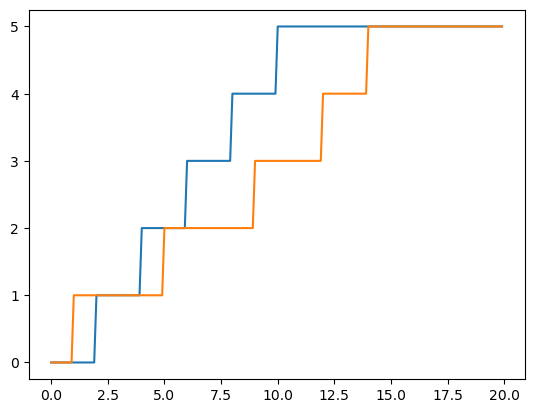

In [12]:
# A possible way to make a smooth layer construction that is continuously defined
def snow_implementation(snow_thickness):
    # The low and high are referring to the index values. The index is low at the snow-air interface and high at the snow-ice interface
    snow_split_low = 5 # [cm] from the air
    snow_split_high = 5 # [cm] from the ice
    if snow_thickness >= (2*snow_split_low+snow_split_high)*1e-2:
        snow_split_low = snow_split_low
        snow_split_high = int(snow_thickness*100 - snow_split_high)
#         print("15 cm wide layer")
    elif snow_thickness >= 2*snow_split_low*1e-2:
        snow_split_low = snow_split_low
        snow_split_high = int(snow_split_low+(snow_thickness*100-snow_split_low)/2)
#         print("10 cm layer")
    else:
        snow_split_low = int(0.5*snow_thickness*100)
        snow_split_high = int(snow_split_low+(snow_thickness*100-snow_split_low)/2)
#         print(">10 cm layer")
    return [snow_split_low, snow_split_high]


snow_thickness_list = np.arange(0, 0.2, 0.001)
snow_split_list = np.zeros((snow_thickness_list.size, 2))
for i in range(snow_thickness_list.size):
    snow_split_list[i] = snow_implementation(snow_thickness_list[i])
plt.figure()
plt.plot(snow_thickness_list*100, snow_split_list[:,0])
plt.plot(snow_thickness_list*100, (snow_thickness_list*100).astype(int)-snow_split_list[:,1])